In [1]:
import cv2 as cv
%load_ext autoreload
%autoreload 2
import os
import sys; sys.path.append('../')
import matplotlib.pyplot as plt

import pandas as pd
import math
import seaborn as sns;
import numpy as np
import tensorflow as tf
from keras import backend as K
from tensorflow import keras
from scipy.spatial.distance import cdist
from tensorflow.keras.optimizers import Adam
from src.utils.keypoints_filter import mean_distance_filter
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import layers, regularizers
from tqdm import tqdm
import pickle
from tqdm import tqdm
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 120
import sys; sys.path.append('../')
color = {
        1:"brown",
        2:"blue",
        3:"green",
        4:"red"
}
import matplotlib.image as mpimg
data_path = "../data/Ki67/SHIDC-B-Ki-67/Train"
img_name= "p1_0299_6"

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
def grey_world(nimg):
    nimg = nimg.transpose(2, 0, 1).astype(np.uint32)
    mu_g = np.average(nimg[1])
    nimg[0] = np.minimum(nimg[0]*(mu_g/np.average(nimg[0])),255)
    nimg[2] = np.minimum(nimg[2]*(mu_g/np.average(nimg[2])),255)
    return  nimg.transpose(1, 2, 0).astype(np.uint8)

In [3]:
def create_keypoints_dict(img_name,data_path,radius=None,plot=False):
    img_path = os.path.join(str(data_path),str(img_name)+".jpg")
    json_path = os.path.join(str(data_path),img_name+".json")
    df = pd.read_json(json_path)
    img = grey_world(mpimg.imread(img_path))
    auto = False
    if plot:
        plt.imshow(img)

        for idx , row in df.iterrows():
                x = row[0]; y = row[1]; label = row[2]
                plt.plot(x, y, marker='*', color=color[label])
        plt.show()
    sift = sift = cv.SIFT_create(
            nOctaveLayers=40,
            contrastThreshold=0.01,
            edgeThreshold=30,
            sigma=1.3)
    keypoints, desc = sift.detectAndCompute(img,None)
    z = [tup for tup in zip(keypoints,desc)if (tup[0].size>=8  and tup[0].size<=150)]
    keypoints, desc = zip(*z)
    if plot:
        img_cv = None
        img_cv=cv.drawKeypoints(img,keypoints,img,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        plt.imshow(img_cv)
        plt.show()
        
    points = list(zip(df.x,df.y))
    if len(points)<=0:
        return None
    
    if radius is None:
        d=cdist(points,points)
        d=d.flatten()
        d.sort()
        radius = d[d>0][0]*0.5
        auto=True
        
    
    keys = [k.pt for k in keypoints]
    distances = cdist(points,keys)
    
    x=np.argwhere(distances <=radius)
    df_features = pd.DataFrame()
    if plot:
        plt.imshow(img)
        
    for pair in x:
        point_idx = pair[0]
        keypoint_idx = pair[1]
        label = df.label_id[point_idx]
        x,y = keypoints[keypoint_idx].pt
        point = img[int(x),int(y)]
        
        keypoint_dict = {
            'angle':keypoints[keypoint_idx].angle,
            'response':keypoints[keypoint_idx].response,
            'size':keypoints[keypoint_idx].size,
            'octave':keypoints[keypoint_idx].octave,
            'desc':desc[keypoint_idx],
            'label': label,
            'pixel':point
        }
        df_features = df_features.append(keypoint_dict,ignore_index=True)
        
        if plot:
            plt.plot(keypoints[keypoint_idx].pt[0],keypoints[keypoint_idx].pt[1],marker='o',color=color[label])
            plt.plot(points[point_idx][0],points[point_idx][1],marker='^',color=color[label])
    if auto:
        distant=np.where(np.all(distances>radius*2,axis=0))[0]
    else:
        distant=np.where(np.all(distances>radius*4,axis=0))[0]
    #print(len(distant))
    for distant_key_idx in distant:
        if keypoints[distant_key_idx].response > 0.002:
            if plot:
                plt.plot(keypoints[distant_key_idx].pt[0],keypoints[distant_key_idx].pt[1],marker='o',color=color[4])
            x,y = keypoints[distant_key_idx].pt
            point = img[int(x),int(y)]
            keypoint_dict = {
                'angle':keypoints[distant_key_idx].angle,
                'response':keypoints[distant_key_idx].response,
                'size':keypoints[distant_key_idx].size,
                'octave':keypoints[distant_key_idx].octave,
                'desc':desc[distant_key_idx],
                'label': 4,
                'pixel':point
                
            }
            df_features = df_features.append(keypoint_dict,ignore_index=True)
    return df_features

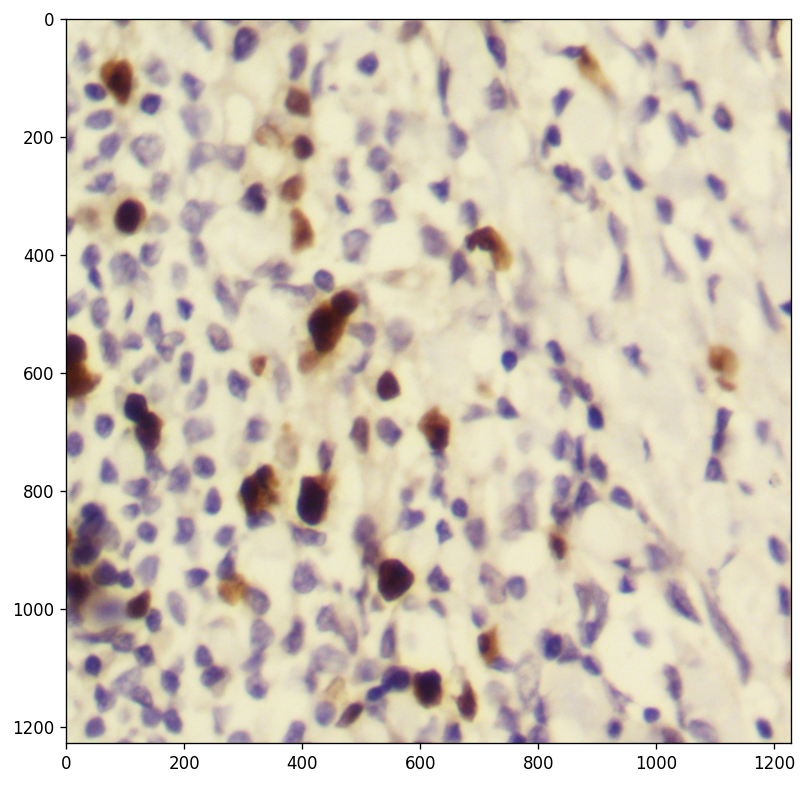

In [4]:
img_path = os.path.join(str(data_path),str(img_name)+".jpg")
json_path = os.path.join(str(data_path),img_name+".json")
df = pd.read_json(json_path)
#img = grey_world()
plt.imshow(mpimg.imread(img_path))

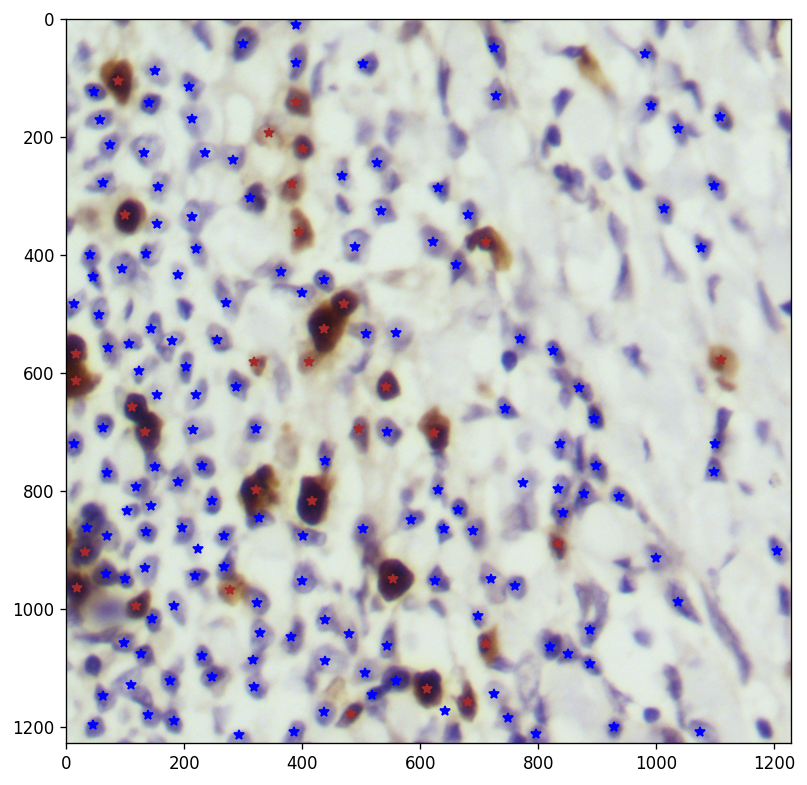

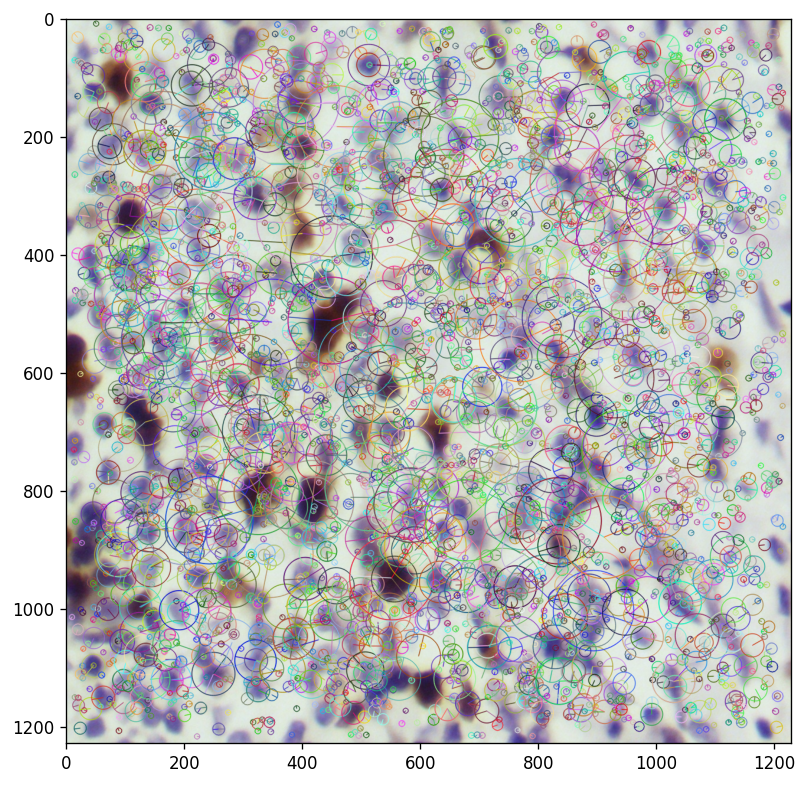

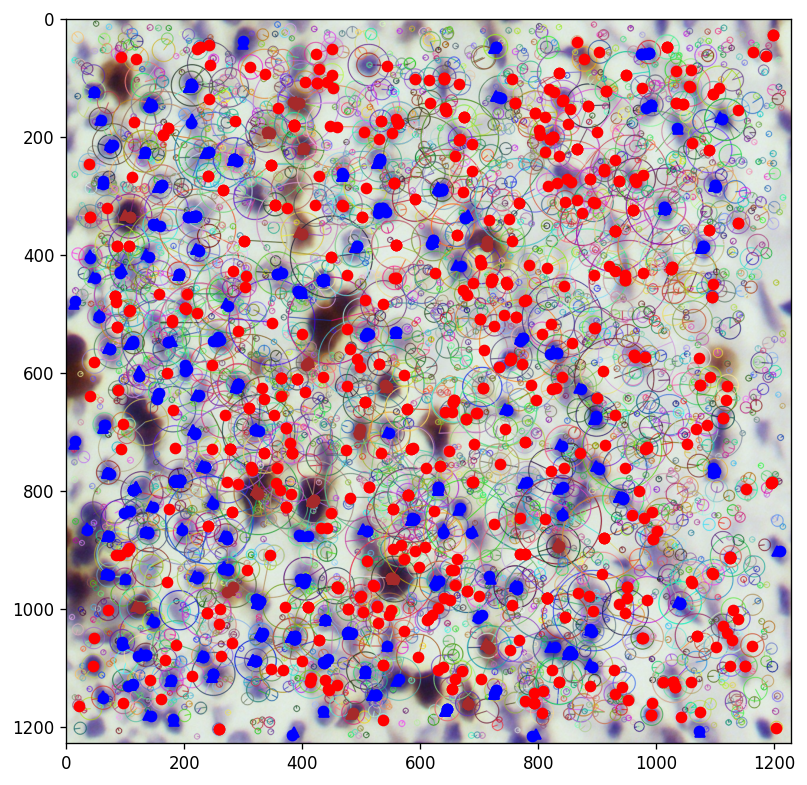

In [5]:
d = create_keypoints_dict(img_name,data_path,plot=True,radius=8)

In [107]:
d.set_index('label').mean(level=0)
#df.sort_values(by=['size'],ascending=False).head(100)

angle        octave  response       size
label                                               
1.0    171.278073  9.438231e+06  0.008817  68.680911
2.0    194.472003  8.062196e+06  0.003873  37.843048
4.0    197.698494  8.384377e+06  0.003751  51.678669

In [108]:
d.response.min()

0.00025239895330742

In [109]:
d.response.max()

0.01392411906272173

In [110]:
path=r"../data/Ki67/SHIDC-B-Ki-67/"
path_type = ["Test","Train"]   

In [111]:
for data_type in path_type:
    df_all = pd.DataFrame()
    root_path = os.path.join(str(path),data_type)
    for root, dirs, files in os.walk(root_path, topdown=False):
        for file in tqdm(files):
            if file.split('.')[1]=='json':
                json_path = os.path.join(root,file)
                size = os.path.getsize(json_path)
                if size > 2:
                    try:
                        img_name = file.split('.')[0]
                        dic = create_keypoints_dict(img_name,data_path=root_path,radius=8)
                        if not dic.empty:
                            df_all = df_all.append(dic,ignore_index=True)
                        pass
                    except Exception as e:
                        print("error with file: ",img_name,' exc: ',e)
                    
                else:
                    #print('empty json', json_path)
                    pass
    with open(r'../keypoints_desc_pixel_info'+data_type+'.pickle', 'wb') as handle:
        pickle.dump(df_all, handle, protocol=pickle.HIGHEST_PROTOCOL)                
    df_all.to_csv(r'../keypoints_descs_pixel_info'+data_type+'.csv',index=False)

100%|████████████████████████████████████████████████████████████████████████████| 3312/3312 [1:43:14<00:00,  1.87s/it]


KeyboardInterrupt: 

In [ ]:
df_all.to_csv(r'../keypoints_descs_0Train'+'.csv',index=False)

In [ ]:
corr = train_set.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

# Dataloading

In [19]:
trainfile = r"../keypoints_desc_pixel_infoTrain.pickle" # keypoints_desc_pixel_infoTrain.pickle
testfile = r"../keypoints_desc_pixel_infoTest.pickle" # keypoints_desc_pixel_infoTest.pickl
with open(trainfile, 'rb') as handle:
    train_set = pickle.load(handle)
with open(testfile, 'rb') as handle:
    test_set = pickle.load(handle)  
train_set.loc[train_set.label !=4, ['label']]=0
train_set.loc[train_set.label ==4, ['label']]=1

test_set.loc[test_set.label !=4, ['label']]=0
test_set.loc[test_set.label ==4, ['label']]=1

test_set=test_set.sample(frac = 1)

train_set=train_set.sample(frac=1)

<AxesSubplot:>

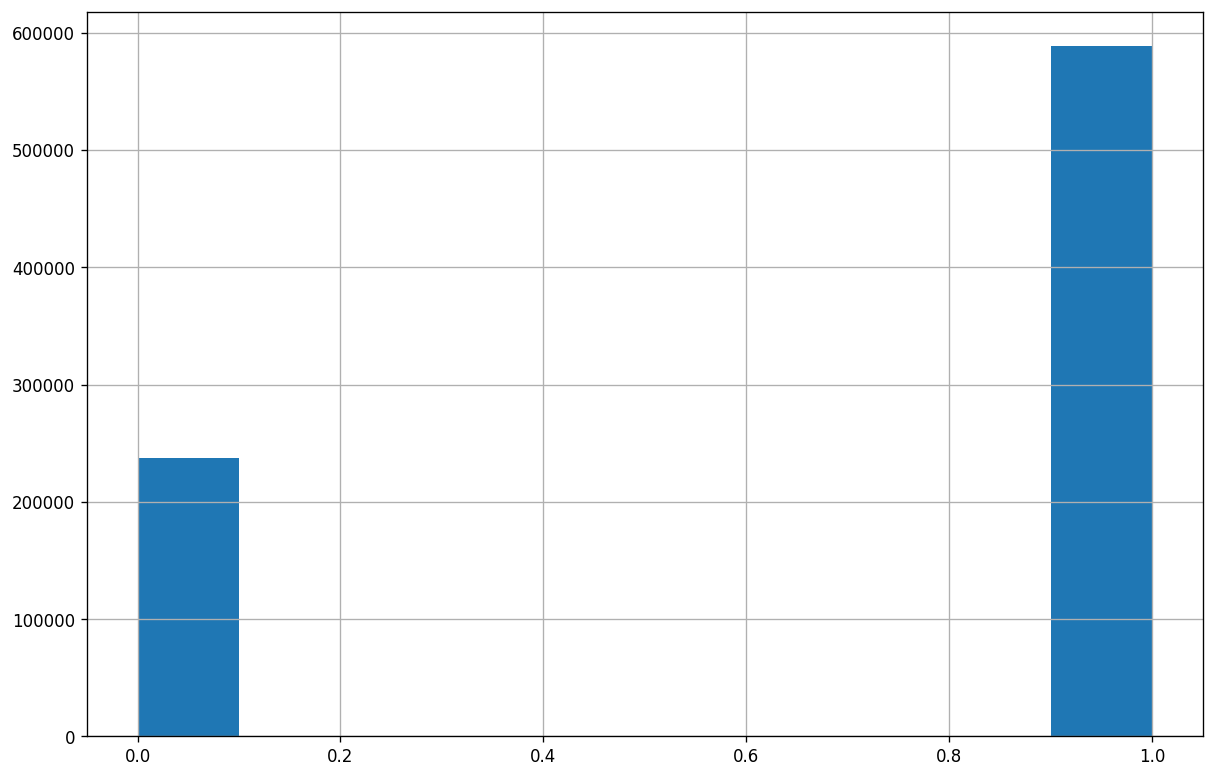

In [20]:
train_set.label.hist()

In [21]:
train_set[train_set.label==1]

angle                                               desc  label  \
191129  211.049820  [0.0, 0.0, 1.0, 10.0, 3.0, 0.0, 0.0, 0.0, 42.0...    1.0   
7855    163.755310  [106.0, 74.0, 19.0, 20.0, 19.0, 20.0, 33.0, 97...    1.0   
791429   22.040985  [69.0, 40.0, 32.0, 30.0, 4.0, 20.0, 47.0, 45.0...    1.0   
25660   306.413818  [46.0, 22.0, 17.0, 33.0, 61.0, 39.0, 29.0, 33....    1.0   
712482  343.633606  [63.0, 72.0, 12.0, 19.0, 121.0, 54.0, 2.0, 8.0...    1.0   
...            ...                                                ...    ...   
242497   59.332428  [4.0, 2.0, 4.0, 29.0, 15.0, 2.0, 9.0, 14.0, 6....    1.0   
111751  346.570862  [5.0, 18.0, 8.0, 2.0, 2.0, 4.0, 10.0, 8.0, 11....    1.0   
279004  269.515015  [105.0, 48.0, 13.0, 0.0, 0.0, 1.0, 12.0, 42.0,...    1.0   
143334   31.867065  [13.0, 17.0, 5.0, 9.0, 3.0, 16.0, 16.0, 11.0, ...    1.0   
455965  237.839615  [44.0, 26.0, 39.0, 9.0, 3.0, 8.0, 14.0, 57.0, ...    1.0   

            octave            pixel  response        size  
191129   2498053.0  [228, 226, 228]  0.003666  139.078140  
7855    15410436.0  [214, 225, 234]  0.005114   79.565559  
791429  15476739.0  [221, 224, 230]  0.003841   41.906887  
25660   12263940.0  [208, 210, 197]  0.006138   75.289917  
712482   7218690.0  [232, 222, 148]  0.004771   20.066978  
...            ...              ...       ...         ...  
242497  14950915.0  [188, 197, 221]  0.003260   37.748589  
111751  10364674.0  [231, 241, 243]  0.003893   20.484869  
279004  16590337.0    [139, 99, 98]  0.002081   10.131938  
143334  11871234.0  [206, 200, 218]  0.002125   19.477701  
455965   9446401.0  [217, 218, 233]  0.002160    9.714410  

[588676 rows x 7 columns]

In [32]:
len(train_set.iloc[0].desc)

128

In [22]:
y_train = train_set.label.values
y_test = test_set.label.values
train_set=train_set.drop(columns=['label'],axis=1)
test_set=test_set.drop(columns=['label'],axis=1)

In [23]:
y_test.max()

1.0

In [24]:
from sklearn.preprocessing import normalize
def process_set(df):
    all_items=[]
    for index, row in tqdm(df.iterrows()):
        items = []
        #print(row[1])
        #items.append(row[0])#angle
        items.extend(row[1]) #desc
      #  items.append(row[2]) #octave
      #  items.extend(row[3]) #pi
      #  items.append(row[4]) #size
        all_items.append(items)
    all_items=normalize(all_items,axis=1)
    return all_items

In [25]:
tf.random.set_seed(0)
physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)
print(physical_devices)

RuntimeError: Physical devices cannot be modified after being initialized

In [15]:

x_list = process_set(train_set)
x = tf.convert_to_tensor(x_list)

x_test_list = process_set(test_set)
x_test = tf.convert_to_tensor(x_test_list)


826023it [00:54, 15219.13it/s]
353510it [00:23, 15207.17it/s]


# Classic - baseline models

In [4]:
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier

In [17]:
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(x_test_list,y_test)

KNeighborsClassifier(n_neighbors=3)

In [18]:
y_pred = neigh.predict(x_test_list)
y_true=y_test
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.86      0.74      0.80    104515
         1.0       0.90      0.95      0.92    248995

    accuracy                           0.89    353510
   macro avg       0.88      0.85      0.86    353510
weighted avg       0.89      0.89      0.89    353510



# Random check

In [14]:
import random
y_true=y_test
#zero check what is model only print out 1 class 
random_output = [random.randint(0, 1) for i in range(len(y_true))]
ones = np.array([1 for item in y_true])
zeros = [0 for item in y_true]
print(classification_report(y_true, ones))
print(classification_report(y_true, zeros))
print(classification_report(y_true, random_output))

c:\users\wilk\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\wilk\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\wilk\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00    104515
         1.0       0.70      1.00      0.83    248995

    accuracy                           0.70    353510
   macro avg       0.35      0.50      0.41    353510
weighted avg       0.50      0.70      0.58    353510



c:\users\wilk\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\wilk\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\wilk\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

              precision    recall  f1-score   support

         0.0       0.30      1.00      0.46    104515
         1.0       0.00      0.00      0.00    248995

    accuracy                           0.30    353510
   macro avg       0.15      0.50      0.23    353510
weighted avg       0.09      0.30      0.13    353510

              precision    recall  f1-score   support

         0.0       0.29      0.50      0.37    104515
         1.0       0.70      0.50      0.58    248995

    accuracy                           0.50    353510
   macro avg       0.50      0.50      0.48    353510
weighted avg       0.58      0.50      0.52    353510



# Deep models

In [17]:
import time
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.utils import class_weight
from sklearn.metrics import f1_score
from tensorflow.keras import regularizers

In [26]:
BATCH_SIZE=4096
EPOCH = 100
from sklearn.metrics import classification_report
def check_model(model,y_true,x_test):
    y_pred=model.predict_classes(x_test)
    print(classification_report(y_true, y_pred))

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
class_weight_dict = dict(enumerate(class_weights))

c:\users\wilk\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0. 1.], y=[1. 1. 1. ... 1. 1. 1.] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [27]:
class_weights

array([1.74011679, 0.70159392])

In [17]:
def create_model(UNITS,DROPS,REGS):
    name="model_seq"
    model = tf.keras.models.Sequential()
    units_it = 0
    drops_it = 0
    while units_it < len(UNITS) and drops_it < len(DROPS):
        if units_it < len(UNITS):
            if units_it ==0:
                model.add(Dense(units=UNITS[units_it], input_shape=(x.shape[1],), activation="relu", name="input_layer"))
                name+="_"+str(UNITS[units_it])
            else:
                if REGS[units_it]==True:
                    model.add(Dense(UNITS[units_it],kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01), activation="relu"))
                    name+="_"+str(UNITS[units_it])+"reg"
                else:
                    model.add(Dense(UNITS[units_it], activation="relu"))
                    name+="_"+str(UNITS[units_it])
                
            units_it +=1
        if drops_it < len(DROPS):
            model.add(Dropout(DROPS[drops_it]))
            model.add(BatchNormalization())
            name+="_"+str(DROPS[drops_it])
            drops_it += 1
            
    model._name = name
    model.add(Dense(units=2, activation="softmax"))
    model.build()
    return model

In [21]:
def train(UNITS,DROPS,REGS,lr=0.001,return_model=False,trial=None):
    results = pd.DataFrame()
    model = create_model(UNITS,DROPS,REGS)
    if trial != None:
        MODEL_NAME = str(trial.number)+"_"+model.name
    else:
         MODEL_NAME = model.name
    save_path = f"./best_models/"+MODEL_NAME
    model_path = save_path+f"/model"
    tb_callback = tf.keras.callbacks.TensorBoard(save_path, update_freq='epoch')
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=model_path,
                                                     save_weights_only=True,
                                                     verbose=0,
                                                     save_best_only=True)
    

    model.compile(optimizer=Adam(learning_rate=lr),loss='sparse_categorical_crossentropy',metrics=['acc'],run_eagerly=False,)
    #print(EPOCH,BATCH_SIZE)
    history_pre = model.fit(
    x,y_train,batch_size=BATCH_SIZE,
    validation_data=(x_test,y_test),
    epochs=EPOCH,class_weight=class_weight_dict,
    callbacks=[tb_callback,cp_callback],verbose=0
    )
    model.load_weights(model_path)
    #check_model(model,y_train,x)
    #check_model(model,y_test,x_test)
    test_results = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE,return_dict=True)
    train_results = model.evaluate(x, y_train, batch_size=BATCH_SIZE,return_dict=True)
    y_pred = tf.argmax(model.predict(x_test),axis=1)
    fs = f1_score(y_test,y_pred)
    #print(train_results)
    raport = classification_report(y_test, y_pred,output_dict=True)
    mean_fs= (raport['1.0']['f1-score']+raport['0.0']['f1-score'])/2
    res = {
        'model_name':[MODEL_NAME],
        'val_loss':test_results['loss'],
        'val_acc':test_results['acc'],
        'train_loss':train_results['loss'],
        'train_acc':train_results['acc'],
        'fscore':[fs],
        'mean_fs':[mean_fs]
    }
    model.save(save_path+f"/model")
    results=results.append(res,ignore_index=True)
    if return_model:
        return results, model
    return results

In [25]:
import tensorflow as tf

import optuna
MAX_UNITS = 2048
MAX_DROP = 0.5

# 1. Define an objective function to be maximized.
def objective(trial):
    BATCH_SIZE= trial.suggest_int('BATCH_SIZE', 256, 8096)    
    # 2. Suggest values of the hyperparameters using a trial object.
    n_dense_layers = trial.suggest_int('n_layers_dense', 1, 8)
    n_drop_layers = trial.suggest_int('n_layers_dropout', 1, n_dense_layers)
    UNITS = []
    DROPS = []
    REGS = []
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
    for i in range(n_dense_layers):
        UNITS.append(int(trial.suggest_loguniform('n_units_Dense_l_{}'.format(i), 4, MAX_UNITS)))
        REGS.append(trial.suggest_categorical('n_regularization_{}'.format(i), [True,False]))
            
    for i in range(n_drop_layers):
        DROPS.append(round(float(trial.suggest_loguniform('n_units_Drop_l_{}'.format(i), 0.1, MAX_DROP)),2))
    res = train(UNITS,DROPS,REGS,lr,False,trial)
    print(res)
    return res['mean_fs'][0]

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2021-05-07 01:27:48,310] A new study created in memory with name: no-name-446a8cb6-bd8a-479c-9ca4-ad6f227e4aac


202/202 [==============================] - 2s 10ms/step - loss: 0.4483 - acc: 0.8539
INFO:tensorflow:Assets written to: ./best_models/0_model_seq_1047_0.42_66reg_0.25_49_0.21/model\assets


[I 2021-05-07 01:34:55,007] Trial 0 finished with value: 0.8002761317714082 and parameters: {'BATCH_SIZE': 5472, 'n_layers_dense': 7, 'n_layers_dropout': 3, 'lr': 0.07107297359788681, 'n_units_Dense_l_0': 1047.9860401086237, 'n_regularization_0': False, 'n_units_Dense_l_1': 66.95252433664386, 'n_regularization_1': True, 'n_units_Dense_l_2': 49.134308925009044, 'n_regularization_2': False, 'n_units_Dense_l_3': 281.5225832554587, 'n_regularization_3': True, 'n_units_Dense_l_4': 5.7092619020843065, 'n_regularization_4': True, 'n_units_Dense_l_5': 59.87143504938908, 'n_regularization_5': False, 'n_units_Dense_l_6': 6.68299617371163, 'n_regularization_6': False, 'n_units_Drop_l_0': 0.41834079222868203, 'n_units_Drop_l_1': 0.24919270449852368, 'n_units_Drop_l_2': 0.2076119701068168}. Best is trial 0 with value: 0.8002761317714082.


                 fscore               mean_fs  \
0  [0.8978612216975306]  [0.8002761317714082]   

                                   model_name  train_acc  train_loss  \
0  [0_model_seq_1047_0.42_66reg_0.25_49_0.21]   0.853861    0.448282   

    val_acc  val_loss  
0  0.847956  0.452294  
202/202 [==============================] - 1s 5ms/step - loss: 0.3190 - acc: 0.8620
INFO:tensorflow:Assets written to: ./best_models/1_model_seq_509_0.33_113_0.2/model\assets


[I 2021-05-07 01:40:16,071] Trial 1 finished with value: 0.8134421709098261 and parameters: {'BATCH_SIZE': 1880, 'n_layers_dense': 2, 'n_layers_dropout': 2, 'lr': 0.014809398670848286, 'n_units_Dense_l_0': 509.8647694310982, 'n_regularization_0': False, 'n_units_Dense_l_1': 113.06287915362908, 'n_regularization_1': False, 'n_units_Drop_l_0': 0.3345084420343815, 'n_units_Drop_l_1': 0.19982931485573155}. Best is trial 1 with value: 0.8134421709098261.


                 fscore               mean_fs                      model_name  \
0  [0.8964994832607811]  [0.8134421709098261]  [1_model_seq_509_0.33_113_0.2]   

   train_acc  train_loss  val_acc  val_loss  
0   0.862024    0.319004  0.85042  0.339284  
202/202 [==============================] - 1s 7ms/step - loss: 0.3557 - acc: 0.8583
INFO:tensorflow:Assets written to: ./best_models/2_model_seq_22_0.18_1604reg_0.41_8reg_0.46/model\assets


[I 2021-05-07 01:47:47,922] Trial 2 finished with value: 0.8025099014715547 and parameters: {'BATCH_SIZE': 1730, 'n_layers_dense': 3, 'n_layers_dropout': 3, 'lr': 8.539591994894793e-05, 'n_units_Dense_l_0': 22.828236330886625, 'n_regularization_0': False, 'n_units_Dense_l_1': 1604.1765438037328, 'n_regularization_1': True, 'n_units_Dense_l_2': 8.950499335200172, 'n_regularization_2': True, 'n_units_Drop_l_0': 0.17671211412876436, 'n_units_Drop_l_1': 0.40690962789797674, 'n_units_Drop_l_2': 0.46494671695594403}. Best is trial 1 with value: 0.8134421709098261.


                 fscore               mean_fs  \
0  [0.9016700313366277]  [0.8025099014715547]   

                                     model_name  train_acc  train_loss  \
0  [2_model_seq_22_0.18_1604reg_0.41_8reg_0.46]   0.858268    0.355665   

    val_acc  val_loss  
0  0.852298   0.36186  
202/202 [==============================] - 2s 10ms/step - loss: 0.3467 - acc: 0.8518
INFO:tensorflow:Assets written to: ./best_models/3_model_seq_961_0.15_200reg_0.28_243_0.27_1461_0.19/model\assets


[I 2021-05-07 02:02:58,429] Trial 3 finished with value: 0.8071108031525629 and parameters: {'BATCH_SIZE': 6818, 'n_layers_dense': 7, 'n_layers_dropout': 4, 'lr': 0.0005861160998429055, 'n_units_Dense_l_0': 961.1486310913101, 'n_regularization_0': True, 'n_units_Dense_l_1': 200.201810162551, 'n_regularization_1': True, 'n_units_Dense_l_2': 243.39425161219395, 'n_regularization_2': False, 'n_units_Dense_l_3': 1461.8748495014663, 'n_regularization_3': False, 'n_units_Dense_l_4': 1137.7036412909526, 'n_regularization_4': True, 'n_units_Dense_l_5': 197.50411534180662, 'n_regularization_5': True, 'n_units_Dense_l_6': 129.79356859025194, 'n_regularization_6': True, 'n_units_Drop_l_0': 0.15074511175234792, 'n_units_Drop_l_1': 0.28218849602798546, 'n_units_Drop_l_2': 0.26700598758456945, 'n_units_Drop_l_3': 0.18863533351888948}. Best is trial 1 with value: 0.8134421709098261.


                fscore               mean_fs  \
0  [0.889257450983115]  [0.8071108031525629]   

                                          model_name  train_acc  train_loss  \
0  [3_model_seq_961_0.15_200reg_0.28_243_0.27_146...   0.851793    0.346747   

    val_acc  val_loss  
0  0.842095  0.362711  
202/202 [==============================] - 1s 7ms/step - loss: 0.4515 - acc: 0.8094
INFO:tensorflow:Assets written to: ./best_models/4_model_seq_10_0.24_759_0.28_430_0.1/model\assets


[I 2021-05-07 02:10:23,585] Trial 4 finished with value: 0.7619583593489042 and parameters: {'BATCH_SIZE': 4306, 'n_layers_dense': 7, 'n_layers_dropout': 3, 'lr': 0.0030375939939332746, 'n_units_Dense_l_0': 10.412704253924232, 'n_regularization_0': False, 'n_units_Dense_l_1': 759.6435125487424, 'n_regularization_1': False, 'n_units_Dense_l_2': 430.2304282954784, 'n_regularization_2': False, 'n_units_Dense_l_3': 74.2830165556129, 'n_regularization_3': False, 'n_units_Dense_l_4': 155.0487951917348, 'n_regularization_4': False, 'n_units_Dense_l_5': 103.05334304032706, 'n_regularization_5': True, 'n_units_Dense_l_6': 6.386695759537443, 'n_regularization_6': False, 'n_units_Drop_l_0': 0.23862430902961299, 'n_units_Drop_l_1': 0.28448644054873506, 'n_units_Drop_l_2': 0.10301574159267009}. Best is trial 1 with value: 0.8134421709098261.


                 fscore               mean_fs  \
0  [0.8627208585908774]  [0.7619583593489042]   

                               model_name  train_acc  train_loss   val_acc  \
0  [4_model_seq_10_0.24_759_0.28_430_0.1]   0.809417    0.451482  0.804611   

   val_loss  
0  0.453532  
202/202 [==============================] - 1s 5ms/step - loss: 0.4368 - acc: 0.8333
INFO:tensorflow:Assets written to: ./best_models/5_model_seq_5_0.15_64reg_0.13/model\assets


[I 2021-05-07 02:14:00,133] Trial 5 finished with value: 0.7794900471796067 and parameters: {'BATCH_SIZE': 6855, 'n_layers_dense': 2, 'n_layers_dropout': 2, 'lr': 2.0034461645602654e-05, 'n_units_Dense_l_0': 5.188906869663655, 'n_regularization_0': True, 'n_units_Dense_l_1': 64.76598625648556, 'n_regularization_1': True, 'n_units_Drop_l_0': 0.14718652081541533, 'n_units_Drop_l_1': 0.12898848580215566}. Best is trial 1 with value: 0.8134421709098261.


                 fscore               mean_fs  \
0  [0.8830176330176329]  [0.7794900471796067]   

                        model_name  train_acc  train_loss   val_acc  val_loss  
0  [5_model_seq_5_0.15_64reg_0.13]   0.833301    0.436783  0.828095  0.437477  
202/202 [==============================] - 1s 4ms/step - loss: 0.3831 - acc: 0.8544
INFO:tensorflow:Assets written to: ./best_models/6_model_seq_11_0.27/model\assets


[I 2021-05-07 02:16:54,498] Trial 6 finished with value: 0.7982783579685457 and parameters: {'BATCH_SIZE': 7185, 'n_layers_dense': 3, 'n_layers_dropout': 1, 'lr': 0.022798383460752945, 'n_units_Dense_l_0': 11.352814579717823, 'n_regularization_0': False, 'n_units_Dense_l_1': 4.695431519975433, 'n_regularization_1': True, 'n_units_Dense_l_2': 14.639999617883234, 'n_regularization_2': True, 'n_units_Drop_l_0': 0.27101292487065287}. Best is trial 1 with value: 0.8134421709098261.


                 fscore               mean_fs             model_name  \
0  [0.8992521627333102]  [0.7982783579685457]  [6_model_seq_11_0.27]   

   train_acc  train_loss   val_acc  val_loss  
0   0.854444     0.38315  0.848822  0.386175  
202/202 [==============================] - 2s 11ms/step - loss: 0.3208 - acc: 0.8680
INFO:tensorflow:Assets written to: ./best_models/7_model_seq_741_0.22_393reg_0.19_334reg_0.36_1410_0.16/model\assets


[I 2021-05-07 02:32:45,977] Trial 7 finished with value: 0.8111933864060173 and parameters: {'BATCH_SIZE': 618, 'n_layers_dense': 7, 'n_layers_dropout': 4, 'lr': 0.00015382676068282836, 'n_units_Dense_l_0': 741.4827374635296, 'n_regularization_0': True, 'n_units_Dense_l_1': 393.4412296462407, 'n_regularization_1': True, 'n_units_Dense_l_2': 334.2954433742963, 'n_regularization_2': True, 'n_units_Dense_l_3': 1410.6668342911962, 'n_regularization_3': False, 'n_units_Dense_l_4': 8.758183917392643, 'n_regularization_4': False, 'n_units_Dense_l_5': 626.5248775567298, 'n_regularization_5': False, 'n_units_Dense_l_6': 8.743911736679364, 'n_regularization_6': False, 'n_units_Drop_l_0': 0.22021924239809249, 'n_units_Drop_l_1': 0.1865320651855987, 'n_units_Drop_l_2': 0.35976302009375, 'n_units_Drop_l_3': 0.16043183533604213}. Best is trial 1 with value: 0.8134421709098261.


                 fscore               mean_fs  \
0  [0.8924751382745004]  [0.8111933864060173]   

                                          model_name  train_acc  train_loss  \
0  [7_model_seq_741_0.22_393reg_0.19_334reg_0.36_...   0.868045    0.320816   

    val_acc  val_loss  
0  0.846185  0.363993  
202/202 [==============================] - 1s 4ms/step - loss: 0.4165 - acc: 0.8458
INFO:tensorflow:Assets written to: ./best_models/8_model_seq_15_0.48/model\assets


[I 2021-05-07 02:35:32,832] Trial 8 finished with value: 0.7928084755868798 and parameters: {'BATCH_SIZE': 289, 'n_layers_dense': 2, 'n_layers_dropout': 1, 'lr': 8.111990965522607e-05, 'n_units_Dense_l_0': 15.518969904478986, 'n_regularization_0': False, 'n_units_Dense_l_1': 722.7342953022571, 'n_regularization_1': True, 'n_units_Drop_l_0': 0.4778782777626137}. Best is trial 1 with value: 0.8134421709098261.


                 fscore               mean_fs             model_name  \
0  [0.8921831595811593]  [0.7928084755868798]  [8_model_seq_15_0.48]   

   train_acc  train_loss   val_acc  val_loss  
0   0.845829    0.416531  0.840471  0.417627  
202/202 [==============================] - 1s 4ms/step - loss: 0.3505 - acc: 0.8536
INFO:tensorflow:Assets written to: ./best_models/9_model_seq_32_0.16_183_0.34/model\assets


[I 2021-05-07 02:39:07,523] Trial 9 finished with value: 0.8049069045645241 and parameters: {'BATCH_SIZE': 4918, 'n_layers_dense': 5, 'n_layers_dropout': 2, 'lr': 0.0032957853827562367, 'n_units_Dense_l_0': 32.01356142876092, 'n_regularization_0': True, 'n_units_Dense_l_1': 183.03770216566818, 'n_regularization_1': False, 'n_units_Dense_l_2': 147.4520621178112, 'n_regularization_2': False, 'n_units_Dense_l_3': 469.65471945076337, 'n_regularization_3': True, 'n_units_Dense_l_4': 248.43429030211965, 'n_regularization_4': False, 'n_units_Drop_l_0': 0.16054870351232778, 'n_units_Drop_l_1': 0.33706786210799383}. Best is trial 1 with value: 0.8134421709098261.


                 fscore               mean_fs                      model_name  \
0  [0.8950450912369569]  [0.8049069045645241]  [9_model_seq_32_0.16_183_0.34]   

   train_acc  train_loss   val_acc  val_loss  
0   0.853618    0.350519  0.846553  0.358009  
202/202 [==============================] - 1s 4ms/step - loss: 0.3435 - acc: 0.8601
INFO:tensorflow:Assets written to: ./best_models/10_model_seq_177_0.37/model\assets


[I 2021-05-07 02:42:09,425] Trial 10 finished with value: 0.8084747843950302 and parameters: {'BATCH_SIZE': 2486, 'n_layers_dense': 1, 'n_layers_dropout': 1, 'lr': 0.025984866427256476, 'n_units_Dense_l_0': 177.91567473838376, 'n_regularization_0': False, 'n_units_Drop_l_0': 0.3676503733553928}. Best is trial 1 with value: 0.8134421709098261.


                 fscore               mean_fs               model_name  \
0  [0.9007233966997531]  [0.8084747843950302]  [10_model_seq_177_0.37]   

   train_acc  train_loss   val_acc  val_loss  
0   0.860095    0.343527  0.852907  0.352405  
202/202 [==============================] - 1s 7ms/step - loss: 0.3437 - acc: 0.8325
INFO:tensorflow:Assets written to: ./best_models/11_model_seq_321_0.3_20_0.15_1535reg_0.5_4_0.1_4_0.34/model\assets


[I 2021-05-07 02:50:50,420] Trial 11 finished with value: 0.7899715469498563 and parameters: {'BATCH_SIZE': 324, 'n_layers_dense': 5, 'n_layers_dropout': 5, 'lr': 0.00036898918734784537, 'n_units_Dense_l_0': 321.0216464071077, 'n_regularization_0': True, 'n_units_Dense_l_1': 20.41959435266017, 'n_regularization_1': False, 'n_units_Dense_l_2': 1535.9781072788428, 'n_regularization_2': True, 'n_units_Dense_l_3': 4.2422346302699365, 'n_regularization_3': False, 'n_units_Dense_l_4': 4.568949112824312, 'n_regularization_4': False, 'n_units_Drop_l_0': 0.2978551008388195, 'n_units_Drop_l_1': 0.15095139797782411, 'n_units_Drop_l_2': 0.49744459895999205, 'n_units_Drop_l_3': 0.10499916279655158, 'n_units_Drop_l_4': 0.3362297322058947}. Best is trial 1 with value: 0.8134421709098261.


                 fscore               mean_fs  \
0  [0.8646795547255637]  [0.7899715469498563]   

                                          model_name  train_acc  train_loss  \
0  [11_model_seq_321_0.3_20_0.15_1535reg_0.5_4_0....   0.832495    0.343653   

    val_acc  val_loss  
0  0.816545  0.364266  
202/202 [==============================] - 3s 16ms/step - loss: 0.3280 - acc: 0.8746
INFO:tensorflow:Assets written to: ./best_models/12_model_seq_435_0.11_303_0.18_1586reg_0.28_41_0.23_22_0.1_990_0.14_1337_0.11/model\assets


[I 2021-05-07 03:47:52,329] Trial 12 finished with value: 0.8132946219181934 and parameters: {'BATCH_SIZE': 2239, 'n_layers_dense': 8, 'n_layers_dropout': 7, 'lr': 0.003886541622505757, 'n_units_Dense_l_0': 435.4149771862583, 'n_regularization_0': True, 'n_units_Dense_l_1': 303.1987278751122, 'n_regularization_1': False, 'n_units_Dense_l_2': 1586.9868603178759, 'n_regularization_2': True, 'n_units_Dense_l_3': 41.63055500583695, 'n_regularization_3': False, 'n_units_Dense_l_4': 22.026605907765408, 'n_regularization_4': False, 'n_units_Dense_l_5': 990.9508742676655, 'n_regularization_5': False, 'n_units_Dense_l_6': 1337.0969710422055, 'n_regularization_6': False, 'n_units_Dense_l_7': 118.03934574436524, 'n_regularization_7': False, 'n_units_Drop_l_0': 0.10802104717503389, 'n_units_Drop_l_1': 0.17551839412883785, 'n_units_Drop_l_2': 0.27571511314575203, 'n_units_Drop_l_3': 0.22638711587336421, 'n_units_Drop_l_4': 0.10083239765487118, 'n_units_Drop_l_5': 0.13723007414078273, 'n_units_Drop_

                 fscore               mean_fs  \
0  [0.9061471553961891]  [0.8132946219181934]   

                                          model_name  train_acc  train_loss  \
0  [12_model_seq_435_0.11_303_0.18_1586reg_0.28_4...     0.8746    0.328048   

    val_acc  val_loss  
0  0.859472  0.362898  
202/202 [==============================] - 1s 4ms/step - loss: 0.3328 - acc: 0.8517
INFO:tensorflow:Assets written to: ./best_models/13_model_seq_87_0.1_31_0.19/model\assets


[I 2021-05-07 03:51:16,521] Trial 13 finished with value: 0.8062300683454251 and parameters: {'BATCH_SIZE': 2861, 'n_layers_dense': 4, 'n_layers_dropout': 2, 'lr': 0.005270613771963268, 'n_units_Dense_l_0': 87.19643607248393, 'n_regularization_0': True, 'n_units_Dense_l_1': 31.22737712393912, 'n_regularization_1': False, 'n_units_Dense_l_2': 1640.8297733866752, 'n_regularization_2': True, 'n_units_Dense_l_3': 15.95437539129974, 'n_regularization_3': False, 'n_units_Drop_l_0': 0.10364735122484425, 'n_units_Drop_l_1': 0.18513292773555218}. Best is trial 1 with value: 0.8134421709098261.


                 fscore               mean_fs                     model_name  \
0  [0.8880677309456995]  [0.8062300683454251]  [13_model_seq_87_0.1_31_0.19]   

   train_acc  train_loss   val_acc  val_loss  
0    0.85168    0.332791  0.840794  0.350442  
202/202 [==============================] - 2s 10ms/step - loss: 0.3372 - acc: 0.8686
INFO:tensorflow:Assets written to: ./best_models/14_model_seq_404_0.1_207_0.1_47reg_0.16_32_0.45_48_0.1_7_0.13_1955reg_0.1_140_0.1/model\assets


[I 2021-05-07 04:06:20,291] Trial 14 finished with value: 0.8116721008051511 and parameters: {'BATCH_SIZE': 3223, 'n_layers_dense': 8, 'n_layers_dropout': 8, 'lr': 0.01241990356626031, 'n_units_Dense_l_0': 404.56492009267, 'n_regularization_0': False, 'n_units_Dense_l_1': 207.44186722445806, 'n_regularization_1': False, 'n_units_Dense_l_2': 47.73518334072431, 'n_regularization_2': True, 'n_units_Dense_l_3': 32.95383347561659, 'n_regularization_3': False, 'n_units_Dense_l_4': 48.38336271834401, 'n_regularization_4': False, 'n_units_Dense_l_5': 7.9856944793080755, 'n_regularization_5': False, 'n_units_Dense_l_6': 1955.3486676186008, 'n_regularization_6': True, 'n_units_Dense_l_7': 140.37242802530437, 'n_regularization_7': False, 'n_units_Drop_l_0': 0.10426309767116482, 'n_units_Drop_l_1': 0.10184064230641698, 'n_units_Drop_l_2': 0.15918619423896915, 'n_units_Drop_l_3': 0.4526315639363821, 'n_units_Drop_l_4': 0.1010998143964546, 'n_units_Drop_l_5': 0.1330796011898385, 'n_units_Drop_l_6': 

                 fscore               mean_fs  \
0  [0.9042724669561755]  [0.8116721008051511]   

                                          model_name  train_acc  train_loss  \
0  [14_model_seq_404_0.1_207_0.1_47reg_0.16_32_0....   0.868627    0.337211   

    val_acc  val_loss  
0  0.857203  0.355241  
202/202 [==============================] - 1s 7ms/step - loss: 0.3383 - acc: 0.8609
INFO:tensorflow:Assets written to: ./best_models/15_model_seq_1746_0.34/model\assets


[I 2021-05-07 04:13:12,850] Trial 15 finished with value: 0.8031614470908051 and parameters: {'BATCH_SIZE': 1621, 'n_layers_dense': 1, 'n_layers_dropout': 1, 'lr': 0.0841672957701731, 'n_units_Dense_l_0': 1746.4621643573287, 'n_regularization_0': True, 'n_units_Drop_l_0': 0.34254358431868914}. Best is trial 1 with value: 0.8134421709098261.


                 fscore               mean_fs                model_name  \
0  [0.9039020720987063]  [0.8031614470908051]  [15_model_seq_1746_0.34]   

   train_acc  train_loss  val_acc  val_loss  
0   0.860907    0.338251  0.85472  0.346561  
202/202 [==============================] - 1s 4ms/step - loss: 0.3292 - acc: 0.8515
INFO:tensorflow:Assets written to: ./best_models/16_model_seq_97_0.12_19_0.19/model\assets


[I 2021-05-07 04:16:36,193] Trial 16 finished with value: 0.80608283273193 and parameters: {'BATCH_SIZE': 1680, 'n_layers_dense': 4, 'n_layers_dropout': 2, 'lr': 0.008367061659102724, 'n_units_Dense_l_0': 97.59558063123012, 'n_regularization_0': False, 'n_units_Dense_l_1': 19.3507185816254, 'n_regularization_1': False, 'n_units_Dense_l_2': 911.6547248255148, 'n_regularization_2': True, 'n_units_Dense_l_3': 4.218910950892706, 'n_regularization_3': True, 'n_units_Drop_l_0': 0.12298471068978875, 'n_units_Drop_l_1': 0.1897707026967286}. Best is trial 1 with value: 0.8134421709098261.


                fscore             mean_fs                      model_name  \
0  [0.888612412468425]  [0.80608283273193]  [16_model_seq_97_0.12_19_0.19]   

   train_acc  train_loss   val_acc  val_loss  
0   0.851519    0.329222  0.841207  0.348442  
202/202 [==============================] - 2s 12ms/step - loss: 0.3791 - acc: 0.8393
INFO:tensorflow:Assets written to: ./best_models/17_model_seq_390_0.21_1882_0.13_4reg_0.29_15_0.34_26reg_0.1_1966_0.28/model\assets


[I 2021-05-07 04:52:28,239] Trial 17 finished with value: 0.7950209665413572 and parameters: {'BATCH_SIZE': 3488, 'n_layers_dense': 6, 'n_layers_dropout': 6, 'lr': 0.0016037599501971126, 'n_units_Dense_l_0': 390.8563706414668, 'n_regularization_0': True, 'n_units_Dense_l_1': 1882.4175028795337, 'n_regularization_1': False, 'n_units_Dense_l_2': 4.875678763697385, 'n_regularization_2': True, 'n_units_Dense_l_3': 15.88109115506776, 'n_regularization_3': False, 'n_units_Dense_l_4': 26.645551285814896, 'n_regularization_4': True, 'n_units_Dense_l_5': 1966.0807616862455, 'n_regularization_5': False, 'n_units_Drop_l_0': 0.20726380434671676, 'n_units_Drop_l_1': 0.13318811472335382, 'n_units_Drop_l_2': 0.2895423966926903, 'n_units_Drop_l_3': 0.3380960482449785, 'n_units_Drop_l_4': 0.10377899276817842, 'n_units_Drop_l_5': 0.27721715205454994}. Best is trial 1 with value: 0.8134421709098261.


                 fscore               mean_fs  \
0  [0.8693615987743891]  [0.7950209665413572]   

                                          model_name  train_acc  train_loss  \
0  [17_model_seq_390_0.21_1882_0.13_4reg_0.29_15_...   0.839256    0.379076   

    val_acc  val_loss  
0  0.821982  0.396322  
202/202 [==============================] - 4s 20ms/step - loss: 0.3873 - acc: 0.8619
INFO:tensorflow:Assets written to: ./best_models/18_model_seq_169_0.46_113_0.22_732reg_0.15_185_0.29_18_0.19_1837_0.11_1810_0.14_5_0.44/model\assets


[I 2021-05-07 06:03:16,232] Trial 18 finished with value: 0.804057714933957 and parameters: {'BATCH_SIZE': 1221, 'n_layers_dense': 8, 'n_layers_dropout': 8, 'lr': 0.026875323058429573, 'n_units_Dense_l_0': 169.80461213580276, 'n_regularization_0': False, 'n_units_Dense_l_1': 113.80258062529288, 'n_regularization_1': False, 'n_units_Dense_l_2': 732.6557779746846, 'n_regularization_2': True, 'n_units_Dense_l_3': 185.53982212072933, 'n_regularization_3': False, 'n_units_Dense_l_4': 18.427891212550115, 'n_regularization_4': False, 'n_units_Dense_l_5': 1837.6796416677894, 'n_regularization_5': False, 'n_units_Dense_l_6': 1810.2778547004482, 'n_regularization_6': False, 'n_units_Dense_l_7': 5.8970809985115755, 'n_regularization_7': False, 'n_units_Drop_l_0': 0.46185957919398174, 'n_units_Drop_l_1': 0.2151962951241398, 'n_units_Drop_l_2': 0.1545513872769307, 'n_units_Drop_l_3': 0.29155933858212374, 'n_units_Drop_l_4': 0.1897627783340479, 'n_units_Drop_l_5': 0.11166061116270742, 'n_units_Drop_

                 fscore              mean_fs  \
0  [0.9044615770199045]  [0.804057714933957]   

                                          model_name  train_acc  train_loss  \
0  [18_model_seq_169_0.46_113_0.22_732reg_0.15_18...    0.86194    0.387282   

    val_acc  val_loss  
0  0.855506  0.396668  
202/202 [==============================] - 2s 9ms/step - loss: 0.3338 - acc: 0.8497
INFO:tensorflow:Assets written to: ./best_models/19_model_seq_1723_0.32_461_0.1/model\assets


[I 2021-05-07 06:14:02,790] Trial 19 finished with value: 0.8063310137368713 and parameters: {'BATCH_SIZE': 3831, 'n_layers_dense': 2, 'n_layers_dropout': 2, 'lr': 0.0014567062752143685, 'n_units_Dense_l_0': 1723.8916473756967, 'n_regularization_0': True, 'n_units_Dense_l_1': 461.76174336778377, 'n_regularization_1': False, 'n_units_Drop_l_0': 0.31750503935267727, 'n_units_Drop_l_1': 0.10104739676197459}. Best is trial 1 with value: 0.8134421709098261.


                 fscore               mean_fs  \
0  [0.8883824344650404]  [0.8063310137368713]   

                         model_name  train_acc  train_loss   val_acc  val_loss  
0  [19_model_seq_1723_0.32_461_0.1]   0.849669    0.333761  0.841094  0.348453  
202/202 [==============================] - 1s 7ms/step - loss: 0.3808 - acc: 0.8544
INFO:tensorflow:Assets written to: ./best_models/20_model_seq_53_0.39_6_0.15_2034reg_0.38/model\assets


[I 2021-05-07 06:22:22,813] Trial 20 finished with value: 0.7975520969936563 and parameters: {'BATCH_SIZE': 2382, 'n_layers_dense': 3, 'n_layers_dropout': 3, 'lr': 0.052524884322878385, 'n_units_Dense_l_0': 53.00658107633442, 'n_regularization_0': True, 'n_units_Dense_l_1': 6.393293971145768, 'n_regularization_1': False, 'n_units_Dense_l_2': 2034.905558428184, 'n_regularization_2': True, 'n_units_Drop_l_0': 0.39398497305266394, 'n_units_Drop_l_1': 0.1528520011919468, 'n_units_Drop_l_2': 0.3773794998244844}. Best is trial 1 with value: 0.8134421709098261.


                 fscore               mean_fs  \
0  [0.8995159503120078]  [0.7975520969936563]   

                                   model_name  train_acc  train_loss  \
0  [20_model_seq_53_0.39_6_0.15_2034reg_0.38]   0.854355    0.380765   

    val_acc  val_loss  
0  0.848907  0.385969  
202/202 [==============================] - 2s 10ms/step - loss: 0.3101 - acc: 0.8761
INFO:tensorflow:Assets written to: ./best_models/21_model_seq_476_0.12_219_0.1_72reg_0.16_39_0.49_50_0.1_4_0.12_1865reg_0.1_217_0.1/model\assets


[I 2021-05-07 06:41:36,497] Trial 21 finished with value: 0.8142440250752243 and parameters: {'BATCH_SIZE': 3024, 'n_layers_dense': 8, 'n_layers_dropout': 8, 'lr': 0.011850492310512582, 'n_units_Dense_l_0': 476.111835061461, 'n_regularization_0': False, 'n_units_Dense_l_1': 219.40076577563096, 'n_regularization_1': False, 'n_units_Dense_l_2': 72.5763812445809, 'n_regularization_2': True, 'n_units_Dense_l_3': 39.82219189925721, 'n_regularization_3': False, 'n_units_Dense_l_4': 50.501386177985346, 'n_regularization_4': False, 'n_units_Dense_l_5': 4.082735121919142, 'n_regularization_5': False, 'n_units_Dense_l_6': 1865.4827818681943, 'n_regularization_6': True, 'n_units_Dense_l_7': 217.3275178650289, 'n_regularization_7': False, 'n_units_Drop_l_0': 0.11758934708589405, 'n_units_Drop_l_1': 0.10000697394917549, 'n_units_Drop_l_2': 0.16441422284670698, 'n_units_Drop_l_3': 0.4928387295776184, 'n_units_Drop_l_4': 0.10270066042488038, 'n_units_Drop_l_5': 0.11678357652012653, 'n_units_Drop_l_6'

                 fscore               mean_fs  \
0  [0.9033302807193971]  [0.8142440250752243]   

                                          model_name  train_acc  train_loss  \
0  [21_model_seq_476_0.12_219_0.1_72reg_0.16_39_0...   0.876101    0.310083   

    val_acc  val_loss  
0  0.856969  0.352966  
202/202 [==============================] - 2s 7ms/step - loss: 0.3109 - acc: 0.8717
INFO:tensorflow:Assets written to: ./best_models/22_model_seq_591_0.12_108_0.12_68reg_0.18_49_0.49_68_0.14_4_0.14_443reg_0.42/model\assets


[I 2021-05-07 06:50:14,180] Trial 22 finished with value: 0.8143947378717722 and parameters: {'BATCH_SIZE': 2360, 'n_layers_dense': 8, 'n_layers_dropout': 7, 'lr': 0.012603644180723912, 'n_units_Dense_l_0': 591.9754273570195, 'n_regularization_0': False, 'n_units_Dense_l_1': 108.6739358694474, 'n_regularization_1': False, 'n_units_Dense_l_2': 68.35154166351516, 'n_regularization_2': True, 'n_units_Dense_l_3': 49.40486446315579, 'n_regularization_3': False, 'n_units_Dense_l_4': 68.21816180201503, 'n_regularization_4': False, 'n_units_Dense_l_5': 4.408109854786836, 'n_regularization_5': False, 'n_units_Dense_l_6': 443.48603104703426, 'n_regularization_6': True, 'n_units_Dense_l_7': 691.2435972255847, 'n_regularization_7': False, 'n_units_Drop_l_0': 0.12055260328812284, 'n_units_Drop_l_1': 0.11947744500377723, 'n_units_Drop_l_2': 0.18134933206547307, 'n_units_Drop_l_3': 0.49303102983342995, 'n_units_Drop_l_4': 0.13812240108277224, 'n_units_Drop_l_5': 0.14312950461122237, 'n_units_Drop_l_6

                 fscore               mean_fs  \
0  [0.9033378337546901]  [0.8143947378717722]   

                                          model_name  train_acc  train_loss  \
0  [22_model_seq_591_0.12_108_0.12_68reg_0.18_49_...   0.871724    0.310942   

    val_acc  val_loss  
0  0.857017  0.344694  
202/202 [==============================] - 1s 7ms/step - loss: 0.3476 - acc: 0.8661
INFO:tensorflow:Assets written to: ./best_models/23_model_seq_698_0.13_103_0.11_55reg_0.13_11_0.49_471_0.18_4_0.18/model\assets


[I 2021-05-07 06:58:29,166] Trial 23 finished with value: 0.8068325380656814 and parameters: {'BATCH_SIZE': 1056, 'n_layers_dense': 6, 'n_layers_dropout': 6, 'lr': 0.010414537234340845, 'n_units_Dense_l_0': 698.6012032580618, 'n_regularization_0': False, 'n_units_Dense_l_1': 103.85574392491995, 'n_regularization_1': False, 'n_units_Dense_l_2': 55.725568080075284, 'n_regularization_2': True, 'n_units_Dense_l_3': 11.860204918999402, 'n_regularization_3': False, 'n_units_Dense_l_4': 471.40109445860116, 'n_regularization_4': False, 'n_units_Dense_l_5': 4.304757187997141, 'n_regularization_5': False, 'n_units_Drop_l_0': 0.1274494658971187, 'n_units_Drop_l_1': 0.11349929077260686, 'n_units_Drop_l_2': 0.12678554587094298, 'n_units_Drop_l_3': 0.4929923619633924, 'n_units_Drop_l_4': 0.18211019949962645, 'n_units_Drop_l_5': 0.18350517883810696}. Best is trial 22 with value: 0.8143947378717722.


                 fscore               mean_fs  \
0  [0.9070997344536188]  [0.8068325380656814]   

                                          model_name  train_acc  train_loss  \
0  [23_model_seq_698_0.13_103_0.11_55reg_0.13_11_...   0.866132    0.347618   

    val_acc  val_loss  
0  0.858878  0.358556  
202/202 [==============================] - 1s 6ms/step - loss: 0.3708 - acc: 0.8562
INFO:tensorflow:Assets written to: ./best_models/24_model_seq_202_0.19_40_0.12_25reg_0.19_104_0.48_81_0.15_14_0.49/model\assets


[I 2021-05-07 07:04:35,026] Trial 24 finished with value: 0.807609081547833 and parameters: {'BATCH_SIZE': 4355, 'n_layers_dense': 6, 'n_layers_dropout': 6, 'lr': 0.03978966802219688, 'n_units_Dense_l_0': 202.8803829452485, 'n_regularization_0': False, 'n_units_Dense_l_1': 40.890542176242775, 'n_regularization_1': False, 'n_units_Dense_l_2': 25.071018958669942, 'n_regularization_2': True, 'n_units_Dense_l_3': 104.36653662959577, 'n_regularization_3': False, 'n_units_Dense_l_4': 81.95654661403819, 'n_regularization_4': False, 'n_units_Dense_l_5': 14.924283909654648, 'n_regularization_5': False, 'n_units_Drop_l_0': 0.18912237529455064, 'n_units_Drop_l_1': 0.11558288909675404, 'n_units_Drop_l_2': 0.1893430056012379, 'n_units_Drop_l_3': 0.4788396981693292, 'n_units_Drop_l_4': 0.14792671980374594, 'n_units_Drop_l_5': 0.4857770635697701}. Best is trial 22 with value: 0.8143947378717722.


                fscore              mean_fs  \
0  [0.895205699124333]  [0.807609081547833]   

                                          model_name  train_acc  train_loss  \
0  [24_model_seq_202_0.19_40_0.12_25reg_0.19_104_...   0.856227    0.370774   

    val_acc  val_loss  
0  0.847492  0.379821  
202/202 [==============================] - 2s 8ms/step - loss: 0.3083 - acc: 0.8689
INFO:tensorflow:Assets written to: ./best_models/25_model_seq_2018_0.13_90_0.1_105reg_0.12_45_0.35/model\assets


[I 2021-05-07 07:14:16,243] Trial 25 finished with value: 0.8100715618628571 and parameters: {'BATCH_SIZE': 3115, 'n_layers_dense': 5, 'n_layers_dropout': 4, 'lr': 0.012318883845660397, 'n_units_Dense_l_0': 2018.240832557134, 'n_regularization_0': False, 'n_units_Dense_l_1': 90.27696363483375, 'n_regularization_1': False, 'n_units_Dense_l_2': 105.50568187112671, 'n_regularization_2': True, 'n_units_Dense_l_3': 45.67614440597958, 'n_regularization_3': False, 'n_units_Dense_l_4': 63.559682913392784, 'n_regularization_4': False, 'n_units_Drop_l_0': 0.13281417760058697, 'n_units_Drop_l_1': 0.10339614546559615, 'n_units_Drop_l_2': 0.12223711943342958, 'n_units_Drop_l_3': 0.35297651703106164}. Best is trial 22 with value: 0.8143947378717722.


                 fscore               mean_fs  \
0  [0.8939992898103479]  [0.8100715618628571]   

                                          model_name  train_acc  train_loss  \
0  [25_model_seq_2018_0.13_90_0.1_105reg_0.12_45_...   0.868901    0.308269   

    val_acc  val_loss  
0  0.847158  0.350536  
202/202 [==============================] - 2s 9ms/step - loss: 0.3609 - acc: 0.8694
INFO:tensorflow:Assets written to: ./best_models/26_model_seq_1199_0.11_140_0.15_27reg_0.17_7reg_0.4_201_0.14_21reg_0.1_312reg_0.49/model\assets


[I 2021-05-07 07:24:53,950] Trial 26 finished with value: 0.8113551988833778 and parameters: {'BATCH_SIZE': 2074, 'n_layers_dense': 8, 'n_layers_dropout': 7, 'lr': 0.018617002617893227, 'n_units_Dense_l_0': 1199.487755458051, 'n_regularization_0': False, 'n_units_Dense_l_1': 140.67540355964786, 'n_regularization_1': False, 'n_units_Dense_l_2': 27.69703006295552, 'n_regularization_2': True, 'n_units_Dense_l_3': 7.861812517403303, 'n_regularization_3': True, 'n_units_Dense_l_4': 201.88422562622674, 'n_regularization_4': False, 'n_units_Dense_l_5': 21.071378514782452, 'n_regularization_5': True, 'n_units_Dense_l_6': 312.5025361000375, 'n_regularization_6': True, 'n_units_Dense_l_7': 1534.7681891294415, 'n_regularization_7': True, 'n_units_Drop_l_0': 0.11396413192298326, 'n_units_Drop_l_1': 0.1452582962691971, 'n_units_Drop_l_2': 0.16962420558049873, 'n_units_Drop_l_3': 0.4013476120337052, 'n_units_Drop_l_4': 0.13540136844754952, 'n_units_Drop_l_5': 0.1040302258254597, 'n_units_Drop_l_6': 

                 fscore               mean_fs  \
0  [0.9060836945836928]  [0.8113551988833778]   

                                          model_name  train_acc  train_loss  \
0  [26_model_seq_1199_0.11_140_0.15_27reg_0.17_7r...   0.869416    0.360939   

    val_acc  val_loss  
0  0.858923  0.378525  
202/202 [==============================] - 1s 7ms/step - loss: 0.3147 - acc: 0.8560
INFO:tensorflow:Assets written to: ./best_models/27_model_seq_655_0.25_42_0.13_140_0.24_108_0.26_37_0.29_4_0.19_498reg_0.42/model\assets


[I 2021-05-07 07:33:40,312] Trial 27 finished with value: 0.8093291626107479 and parameters: {'BATCH_SIZE': 2733, 'n_layers_dense': 8, 'n_layers_dropout': 7, 'lr': 0.007029887997703229, 'n_units_Dense_l_0': 655.162661920001, 'n_regularization_0': False, 'n_units_Dense_l_1': 42.266349245346234, 'n_regularization_1': False, 'n_units_Dense_l_2': 140.9797324516122, 'n_regularization_2': False, 'n_units_Dense_l_3': 108.50393043101451, 'n_regularization_3': False, 'n_units_Dense_l_4': 37.19431295713523, 'n_regularization_4': False, 'n_units_Dense_l_5': 4.4308259091166295, 'n_regularization_5': False, 'n_units_Dense_l_6': 498.54881669963095, 'n_regularization_6': True, 'n_units_Dense_l_7': 1211.5700958862185, 'n_regularization_7': False, 'n_units_Drop_l_0': 0.25385598206770976, 'n_units_Drop_l_1': 0.12531290856220095, 'n_units_Drop_l_2': 0.23720227628040058, 'n_units_Drop_l_3': 0.2601386409077484, 'n_units_Drop_l_4': 0.2859441494065545, 'n_units_Drop_l_5': 0.19282105070462358, 'n_units_Drop_l

                 fscore               mean_fs  \
0  [0.8890192276232998]  [0.8093291626107479]   

                                          model_name  train_acc  train_loss  \
0  [27_model_seq_655_0.25_42_0.13_140_0.24_108_0....   0.855997    0.314736   

    val_acc  val_loss  
0  0.842635  0.339278  
202/202 [==============================] - 1s 6ms/step - loss: 0.3215 - acc: 0.8594
INFO:tensorflow:Assets written to: ./best_models/28_model_seq_249_0.17_290_0.46_82reg_0.13_24_0.1_10reg_0.13/model\assets


[I 2021-05-07 07:39:58,462] Trial 28 finished with value: 0.8097981344121841 and parameters: {'BATCH_SIZE': 1077, 'n_layers_dense': 6, 'n_layers_dropout': 5, 'lr': 0.001992379541470133, 'n_units_Dense_l_0': 249.8845453526411, 'n_regularization_0': False, 'n_units_Dense_l_1': 290.13676968183347, 'n_regularization_1': False, 'n_units_Dense_l_2': 82.54452950440225, 'n_regularization_2': True, 'n_units_Dense_l_3': 24.311836485624426, 'n_regularization_3': False, 'n_units_Dense_l_4': 10.672233720376468, 'n_regularization_4': True, 'n_units_Dense_l_5': 30.75554816012266, 'n_regularization_5': False, 'n_units_Drop_l_0': 0.16722983609915631, 'n_units_Drop_l_1': 0.45814119448798074, 'n_units_Drop_l_2': 0.13263821718943697, 'n_units_Drop_l_3': 0.10391055334837929, 'n_units_Drop_l_4': 0.13404991806775735}. Best is trial 22 with value: 0.8143947378717722.


                 fscore               mean_fs  \
0  [0.8926662318803458]  [0.8097981344121841]   

                                          model_name  train_acc  train_loss  \
0  [28_model_seq_249_0.17_290_0.46_82reg_0.13_24_...   0.859441     0.32147   

    val_acc  val_loss  
0  0.845903  0.345416  
202/202 [==============================] - 2s 9ms/step - loss: 0.3764 - acc: 0.8650
INFO:tensorflow:Assets written to: ./best_models/29_model_seq_107_0.2_690_0.23_25reg_0.1_563_0.14_479_0.47_7_0.15_541reg_0.26/model\assets


[I 2021-05-07 07:51:36,398] Trial 29 finished with value: 0.8082241976622473 and parameters: {'BATCH_SIZE': 3848, 'n_layers_dense': 7, 'n_layers_dropout': 7, 'lr': 0.041921460205885636, 'n_units_Dense_l_0': 107.37501351695093, 'n_regularization_0': False, 'n_units_Dense_l_1': 690.850280288453, 'n_regularization_1': False, 'n_units_Dense_l_2': 25.933025918253808, 'n_regularization_2': True, 'n_units_Dense_l_3': 563.1175494360189, 'n_regularization_3': False, 'n_units_Dense_l_4': 479.6288264895581, 'n_regularization_4': False, 'n_units_Dense_l_5': 7.575764148603774, 'n_regularization_5': False, 'n_units_Dense_l_6': 541.0349856072876, 'n_regularization_6': True, 'n_units_Drop_l_0': 0.20185520835245427, 'n_units_Drop_l_1': 0.2274118497422531, 'n_units_Drop_l_2': 0.10143501038619321, 'n_units_Drop_l_3': 0.14274807490228272, 'n_units_Drop_l_4': 0.4664785108341544, 'n_units_Drop_l_5': 0.14884002037609212, 'n_units_Drop_l_6': 0.25806923744126564}. Best is trial 22 with value: 0.814394737871772

                fscore               mean_fs  \
0  [0.905412990953004]  [0.8082241976622473]   

                                          model_name  train_acc  train_loss  \
0  [29_model_seq_107_0.2_690_0.23_25reg_0.1_563_0...   0.864981    0.376367   

    val_acc  val_loss  
0  0.857478  0.389009  
202/202 [==============================] - 1s 6ms/step - loss: 0.3388 - acc: 0.8578
INFO:tensorflow:Assets written to: ./best_models/30_model_seq_1235_0.14/model\assets


[I 2021-05-07 07:57:08,842] Trial 30 finished with value: 0.807331288697444 and parameters: {'BATCH_SIZE': 5582, 'n_layers_dense': 1, 'n_layers_dropout': 1, 'lr': 0.0867966760823941, 'n_units_Dense_l_0': 1235.7552925856874, 'n_regularization_0': False, 'n_units_Drop_l_0': 0.1379071261708965}. Best is trial 22 with value: 0.8143947378717722.


                fscore              mean_fs                model_name  \
0  [0.899421602440677]  [0.807331288697444]  [30_model_seq_1235_0.14]   

   train_acc  train_loss   val_acc  val_loss  
0   0.857843    0.338784  0.851348  0.347764  
202/202 [==============================] - 3s 14ms/step - loss: 0.3184 - acc: 0.8784
INFO:tensorflow:Assets written to: ./best_models/31_model_seq_488_0.11_351_0.17_203reg_0.24_46_0.22_18_0.1_489_0.1_1800reg_0.1_167_0.1/model\assets


[I 2021-05-07 08:24:39,223] Trial 31 finished with value: 0.8135252899278456 and parameters: {'BATCH_SIZE': 2075, 'n_layers_dense': 8, 'n_layers_dropout': 8, 'lr': 0.004813761548430835, 'n_units_Dense_l_0': 488.8417120230124, 'n_regularization_0': False, 'n_units_Dense_l_1': 351.0235178550747, 'n_regularization_1': False, 'n_units_Dense_l_2': 203.14004199882046, 'n_regularization_2': True, 'n_units_Dense_l_3': 46.380934824629314, 'n_regularization_3': False, 'n_units_Dense_l_4': 18.16406536603929, 'n_regularization_4': False, 'n_units_Dense_l_5': 489.8672874216696, 'n_regularization_5': False, 'n_units_Dense_l_6': 1800.2677090455923, 'n_regularization_6': True, 'n_units_Dense_l_7': 167.48380557809404, 'n_regularization_7': False, 'n_units_Drop_l_0': 0.1108226826725861, 'n_units_Drop_l_1': 0.16587003954417728, 'n_units_Drop_l_2': 0.23908474655560377, 'n_units_Drop_l_3': 0.22093712816633623, 'n_units_Drop_l_4': 0.10475268904194493, 'n_units_Drop_l_5': 0.10191571216495553, 'n_units_Drop_l

                 fscore               mean_fs  \
0  [0.9053790259304605]  [0.8135252899278456]   

                                          model_name  train_acc  train_loss  \
0  [31_model_seq_488_0.11_351_0.17_203reg_0.24_46...   0.878404    0.318433   

    val_acc  val_loss  
0  0.858771  0.382221  
202/202 [==============================] - 2s 11ms/step - loss: 0.3973 - acc: 0.8683
INFO:tensorflow:Assets written to: ./best_models/32_model_seq_671_0.12_260_0.16_234reg_0.22_63_0.21_105_0.12_279_0.1_826reg_0.18_343_0.11/model\assets


[I 2021-05-07 08:39:13,546] Trial 32 finished with value: 0.8114104544199228 and parameters: {'BATCH_SIZE': 1623, 'n_layers_dense': 8, 'n_layers_dropout': 8, 'lr': 0.01439118251704937, 'n_units_Dense_l_0': 671.8179873459649, 'n_regularization_0': False, 'n_units_Dense_l_1': 260.4383940920036, 'n_regularization_1': False, 'n_units_Dense_l_2': 234.13409707603915, 'n_regularization_2': True, 'n_units_Dense_l_3': 63.619000208069224, 'n_regularization_3': False, 'n_units_Dense_l_4': 105.15538854222862, 'n_regularization_4': False, 'n_units_Dense_l_5': 279.79992269892375, 'n_regularization_5': False, 'n_units_Dense_l_6': 826.3310473256457, 'n_regularization_6': True, 'n_units_Dense_l_7': 343.10152281994095, 'n_regularization_7': False, 'n_units_Drop_l_0': 0.11702030514286706, 'n_units_Drop_l_1': 0.15814878783553304, 'n_units_Drop_l_2': 0.22399021635621003, 'n_units_Drop_l_3': 0.21234500823610436, 'n_units_Drop_l_4': 0.11731743946936384, 'n_units_Drop_l_5': 0.1025854783910898, 'n_units_Drop_l

                 fscore               mean_fs  \
0  [0.9046990891008158]  [0.8114104544199228]   

                                          model_name  train_acc  train_loss  \
0  [32_model_seq_671_0.12_260_0.16_234reg_0.22_63...   0.868291    0.397266   

    val_acc  val_loss  
0  0.857557  0.419724  
202/202 [==============================] - 1s 7ms/step - loss: 0.2942 - acc: 0.8733
INFO:tensorflow:Assets written to: ./best_models/33_model_seq_502_0.1_64_0.22_80reg_0.19_23_0.28_13_0.16_305_0.1_167reg_0.31/model\assets


[I 2021-05-07 08:47:27,995] Trial 33 finished with value: 0.8095908208832521 and parameters: {'BATCH_SIZE': 1974, 'n_layers_dense': 7, 'n_layers_dropout': 7, 'lr': 0.0008059537588384122, 'n_units_Dense_l_0': 502.783324591519, 'n_regularization_0': False, 'n_units_Dense_l_1': 64.77327829353264, 'n_regularization_1': False, 'n_units_Dense_l_2': 80.85551289273468, 'n_regularization_2': True, 'n_units_Dense_l_3': 23.42042808254238, 'n_regularization_3': False, 'n_units_Dense_l_4': 13.342852693033844, 'n_regularization_4': False, 'n_units_Dense_l_5': 305.1475096192595, 'n_regularization_5': False, 'n_units_Dense_l_6': 167.3465567019631, 'n_regularization_6': True, 'n_units_Drop_l_0': 0.10026903802380933, 'n_units_Drop_l_1': 0.2239261742090255, 'n_units_Drop_l_2': 0.18826800655603143, 'n_units_Drop_l_3': 0.2752916089268979, 'n_units_Drop_l_4': 0.16151116758453246, 'n_units_Drop_l_5': 0.10085686916363336, 'n_units_Drop_l_6': 0.3124073885502359}. Best is trial 22 with value: 0.8143947378717722

                 fscore               mean_fs  \
0  [0.8913437999093592]  [0.8095908208832521]   

                                          model_name  train_acc  train_loss  \
0  [33_model_seq_502_0.1_64_0.22_80reg_0.19_23_0....   0.873264     0.29416   

    val_acc  val_loss  
0  0.844692  0.344346  
202/202 [==============================] - 1s 6ms/step - loss: 0.3233 - acc: 0.8609
INFO:tensorflow:Assets written to: ./best_models/34_model_seq_293_0.15_526_0.17_179reg_0.15/model\assets


[I 2021-05-07 08:54:02,114] Trial 34 finished with value: 0.8101231193207381 and parameters: {'BATCH_SIZE': 2636, 'n_layers_dense': 7, 'n_layers_dropout': 3, 'lr': 0.006179230507063631, 'n_units_Dense_l_0': 293.90520608358224, 'n_regularization_0': False, 'n_units_Dense_l_1': 526.545392221479, 'n_regularization_1': False, 'n_units_Dense_l_2': 179.12701367410702, 'n_regularization_2': True, 'n_units_Dense_l_3': 117.76727350023386, 'n_regularization_3': False, 'n_units_Dense_l_4': 36.634603749971454, 'n_regularization_4': False, 'n_units_Dense_l_5': 8.563005363670655, 'n_regularization_5': False, 'n_units_Dense_l_6': 28.81444981641898, 'n_regularization_6': True, 'n_units_Drop_l_0': 0.15234842594920336, 'n_units_Drop_l_1': 0.167376424934682, 'n_units_Drop_l_2': 0.14620259422794085}. Best is trial 22 with value: 0.8143947378717722.


                 fscore               mean_fs  \
0  [0.8908714170599746]  [0.8101231193207381]   

                                     model_name  train_acc  train_loss  \
0  [34_model_seq_293_0.15_526_0.17_179reg_0.15]   0.860909    0.323335   

    val_acc  val_loss  
0  0.844463  0.353186  
202/202 [==============================] - 3s 13ms/step - loss: 0.3449 - acc: 0.8683
INFO:tensorflow:Assets written to: ./best_models/35_model_seq_977_0.14_1237_0.21_507reg_0.19_63_0.37_124_0.12/model\assets


[I 2021-05-07 09:12:16,688] Trial 35 finished with value: 0.8099316329723476 and parameters: {'BATCH_SIZE': 1261, 'n_layers_dense': 7, 'n_layers_dropout': 5, 'lr': 0.0025446575476334434, 'n_units_Dense_l_0': 977.7892448875043, 'n_regularization_0': False, 'n_units_Dense_l_1': 1237.1561972532759, 'n_regularization_1': False, 'n_units_Dense_l_2': 507.08126560966434, 'n_regularization_2': True, 'n_units_Dense_l_3': 63.03439083375986, 'n_regularization_3': False, 'n_units_Dense_l_4': 124.45552423935791, 'n_regularization_4': False, 'n_units_Dense_l_5': 609.1616216371698, 'n_regularization_5': False, 'n_units_Dense_l_6': 1971.211785999301, 'n_regularization_6': True, 'n_units_Drop_l_0': 0.13966899886892897, 'n_units_Drop_l_1': 0.2060842184973918, 'n_units_Drop_l_2': 0.1863218812010623, 'n_units_Drop_l_3': 0.3668578307663697, 'n_units_Drop_l_4': 0.11735999956986887}. Best is trial 22 with value: 0.8143947378717722.


                 fscore               mean_fs  \
0  [0.8910119132600454]  [0.8099316329723476]   

                                          model_name  train_acc  train_loss  \
0  [35_model_seq_977_0.14_1237_0.21_507reg_0.19_6...   0.868281    0.344867   

    val_acc  val_loss  
0  0.844519  0.384051  
202/202 [==============================] - 1s 7ms/step - loss: 0.3076 - acc: 0.8709
INFO:tensorflow:Assets written to: ./best_models/36_model_seq_134_0.18_167_0.26_47_0.24_174_0.17_58_0.12_57_0.26_56reg_0.11_445_0.1/model\assets


[I 2021-05-07 09:20:47,441] Trial 36 finished with value: 0.8094081703928462 and parameters: {'BATCH_SIZE': 3361, 'n_layers_dense': 8, 'n_layers_dropout': 8, 'lr': 0.004830381686805181, 'n_units_Dense_l_0': 134.963694935895, 'n_regularization_0': False, 'n_units_Dense_l_1': 167.11546537295084, 'n_regularization_1': False, 'n_units_Dense_l_2': 47.969351743881866, 'n_regularization_2': False, 'n_units_Dense_l_3': 174.46610488176572, 'n_regularization_3': False, 'n_units_Dense_l_4': 58.95353868382372, 'n_regularization_4': False, 'n_units_Dense_l_5': 57.69054935001934, 'n_regularization_5': False, 'n_units_Dense_l_6': 56.53743410178219, 'n_regularization_6': True, 'n_units_Dense_l_7': 445.1712887153267, 'n_regularization_7': False, 'n_units_Drop_l_0': 0.18147401015199915, 'n_units_Drop_l_1': 0.26285490304979875, 'n_units_Drop_l_2': 0.24060368907375293, 'n_units_Drop_l_3': 0.16744171280467338, 'n_units_Drop_l_4': 0.11872684403070224, 'n_units_Drop_l_5': 0.2636334326924456, 'n_units_Drop_l_

                 fscore               mean_fs  \
0  [0.9082397736311597]  [0.8094081703928462]   

                                          model_name  train_acc  train_loss  \
0  [36_model_seq_134_0.18_167_0.26_47_0.24_174_0....    0.87091    0.307628   

    val_acc  val_loss  
0  0.860657  0.330293  
202/202 [==============================] - 1s 5ms/step - loss: 0.3075 - acc: 0.8614
INFO:tensorflow:Assets written to: ./best_models/37_model_seq_542_0.12_77_0.14/model\assets


[I 2021-05-07 09:25:23,377] Trial 37 finished with value: 0.8092335610072597 and parameters: {'BATCH_SIZE': 4824, 'n_layers_dense': 2, 'n_layers_dropout': 2, 'lr': 0.019207398322533275, 'n_units_Dense_l_0': 542.6574727502964, 'n_regularization_0': False, 'n_units_Dense_l_1': 77.12350497936224, 'n_regularization_1': False, 'n_units_Drop_l_0': 0.11740958194211853, 'n_units_Drop_l_1': 0.1392987335409945}. Best is trial 22 with value: 0.8143947378717722.


                 fscore               mean_fs  \
0  [0.8887531245757365]  [0.8092335610072597]   

                        model_name  train_acc  train_loss   val_acc  val_loss  
0  [37_model_seq_542_0.12_77_0.14]   0.861376    0.307491  0.842381  0.342331  
202/202 [==============================] - 2s 10ms/step - loss: 0.3336 - acc: 0.8669
INFO:tensorflow:Assets written to: ./best_models/38_model_seq_1026_0.28_1027_0.11_64reg_0.32/model\assets


[I 2021-05-07 09:37:28,854] Trial 38 finished with value: 0.814180646990726 and parameters: {'BATCH_SIZE': 2930, 'n_layers_dense': 3, 'n_layers_dropout': 3, 'lr': 0.03315151994639024, 'n_units_Dense_l_0': 1026.9344868517032, 'n_regularization_0': False, 'n_units_Dense_l_1': 1027.971716108053, 'n_regularization_1': False, 'n_units_Dense_l_2': 64.04661625702076, 'n_regularization_2': True, 'n_units_Drop_l_0': 0.284943190500849, 'n_units_Drop_l_1': 0.11314802471192915, 'n_units_Drop_l_2': 0.3169854500787487}. Best is trial 22 with value: 0.8143947378717722.


                 fscore              mean_fs  \
0  [0.9008005031844554]  [0.814180646990726]   

                                      model_name  train_acc  train_loss  \
0  [38_model_seq_1026_0.28_1027_0.11_64reg_0.32]   0.866938    0.333646   

    val_acc  val_loss  
0  0.854559  0.357565  
202/202 [==============================] - 3s 13ms/step - loss: 0.3601 - acc: 0.8731
INFO:tensorflow:Assets written to: ./best_models/39_model_seq_1359_0.24_1185_0.11_64reg_0.32_28reg_0.42/model\assets


[I 2021-05-07 09:54:33,159] Trial 39 finished with value: 0.8128098026958988 and parameters: {'BATCH_SIZE': 3740, 'n_layers_dense': 4, 'n_layers_dropout': 4, 'lr': 0.030948566851895603, 'n_units_Dense_l_0': 1359.699768553613, 'n_regularization_0': False, 'n_units_Dense_l_1': 1185.2829163451515, 'n_regularization_1': False, 'n_units_Dense_l_2': 64.33288775038066, 'n_regularization_2': True, 'n_units_Dense_l_3': 28.607005603856802, 'n_regularization_3': True, 'n_units_Drop_l_0': 0.24090405881151924, 'n_units_Drop_l_1': 0.1147148997558508, 'n_units_Drop_l_2': 0.3165078066998386, 'n_units_Drop_l_3': 0.41887810016598753}. Best is trial 22 with value: 0.8143947378717722.


                 fscore               mean_fs  \
0  [0.9048825347465822]  [0.8128098026958988]   

                                          model_name  train_acc  train_loss  \
0  [39_model_seq_1359_0.24_1185_0.11_64reg_0.32_2...   0.873117    0.360062   

    val_acc  val_loss  
0  0.858097  0.386751  
202/202 [==============================] - 2s 10ms/step - loss: 0.3426 - acc: 0.8710
INFO:tensorflow:Assets written to: ./best_models/40_model_seq_922_0.28_1296_0.11_34reg_0.34/model\assets


[I 2021-05-07 10:07:18,414] Trial 40 finished with value: 0.8152923063956934 and parameters: {'BATCH_SIZE': 4232, 'n_layers_dense': 3, 'n_layers_dropout': 3, 'lr': 0.05738864956698272, 'n_units_Dense_l_0': 922.7407782284131, 'n_regularization_0': False, 'n_units_Dense_l_1': 1296.4417893456778, 'n_regularization_1': False, 'n_units_Dense_l_2': 34.08262813764225, 'n_regularization_2': True, 'n_units_Drop_l_0': 0.2759202920779446, 'n_units_Drop_l_1': 0.11069000120823817, 'n_units_Drop_l_2': 0.3388773227395907}. Best is trial 40 with value: 0.8152923063956934.


                 fscore               mean_fs  \
0  [0.9058869079024783]  [0.8152923063956934]   

                                     model_name  train_acc  train_loss  \
0  [40_model_seq_922_0.28_1296_0.11_34reg_0.34]   0.871044    0.342606   

    val_acc  val_loss  
0  0.859727  0.364838  
202/202 [==============================] - 2s 10ms/step - loss: 0.3292 - acc: 0.8706
INFO:tensorflow:Assets written to: ./best_models/41_model_seq_976_0.29_1011_0.11_36reg_0.38/model\assets


[I 2021-05-07 10:18:42,173] Trial 41 finished with value: 0.8132775330457716 and parameters: {'BATCH_SIZE': 5665, 'n_layers_dense': 3, 'n_layers_dropout': 3, 'lr': 0.050157265598454875, 'n_units_Dense_l_0': 976.8805219207698, 'n_regularization_0': False, 'n_units_Dense_l_1': 1011.459897500795, 'n_regularization_1': False, 'n_units_Dense_l_2': 36.26464693693502, 'n_regularization_2': True, 'n_units_Drop_l_0': 0.29272142056923195, 'n_units_Drop_l_1': 0.11169805033961026, 'n_units_Drop_l_2': 0.3764870901543993}. Best is trial 40 with value: 0.8152923063956934.


                 fscore               mean_fs  \
0  [0.9048571623786279]  [0.8132775330457716]   

                                     model_name  train_acc  train_loss  \
0  [41_model_seq_976_0.29_1011_0.11_36reg_0.38]   0.870625    0.329212   

    val_acc  val_loss  
0  0.858194  0.358734  
202/202 [==============================] - 2s 11ms/step - loss: 0.3480 - acc: 0.8627
INFO:tensorflow:Assets written to: ./best_models/42_model_seq_845_0.27_1693_0.13_13reg_0.33/model\assets


[I 2021-05-07 10:38:23,932] Trial 42 finished with value: 0.8129128037847901 and parameters: {'BATCH_SIZE': 4493, 'n_layers_dense': 3, 'n_layers_dropout': 3, 'lr': 0.07065375243184148, 'n_units_Dense_l_0': 845.8176357532772, 'n_regularization_0': False, 'n_units_Dense_l_1': 1693.7512167246475, 'n_regularization_1': False, 'n_units_Dense_l_2': 13.392301887819432, 'n_regularization_2': True, 'n_units_Drop_l_0': 0.2667391453191003, 'n_units_Drop_l_1': 0.12591414144081509, 'n_units_Drop_l_2': 0.3276926131909603}. Best is trial 40 with value: 0.8152923063956934.


                 fscore               mean_fs  \
0  [0.8979850580836858]  [0.8129128037847901]   

                                     model_name  train_acc  train_loss  \
0  [42_model_seq_845_0.27_1693_0.13_13reg_0.33]   0.862742    0.347994   

    val_acc  val_loss  
0  0.851597  0.367721  
202/202 [==============================] - 2s 9ms/step - loss: 0.3532 - acc: 0.8569
INFO:tensorflow:Assets written to: ./best_models/43_model_seq_1373_0.28_542reg_0.1_99reg_0.21/model\assets


[I 2021-05-07 10:49:26,990] Trial 43 finished with value: 0.8068097256037552 and parameters: {'BATCH_SIZE': 2900, 'n_layers_dense': 3, 'n_layers_dropout': 3, 'lr': 0.00781389702977911, 'n_units_Dense_l_0': 1373.2675460361813, 'n_regularization_0': False, 'n_units_Dense_l_1': 542.2309223848404, 'n_regularization_1': True, 'n_units_Dense_l_2': 99.07924744570356, 'n_regularization_2': True, 'n_units_Drop_l_0': 0.2813633605770252, 'n_units_Drop_l_1': 0.1007973259454769, 'n_units_Drop_l_2': 0.208276663295204}. Best is trial 40 with value: 0.8152923063956934.


                 fscore               mean_fs  \
0  [0.8958539872358882]  [0.8068097256037552]   

                                       model_name  train_acc  train_loss  \
0  [43_model_seq_1373_0.28_542reg_0.1_99reg_0.21]   0.856912    0.353172   

    val_acc  val_loss  
0  0.847852  0.367528  
202/202 [==============================] - 1s 5ms/step - loss: 0.3950 - acc: 0.8188
INFO:tensorflow:Assets written to: ./best_models/44_model_seq_303_0.31_375_0.12/model\assets


[I 2021-05-07 10:54:30,364] Trial 44 finished with value: 0.7828261002668024 and parameters: {'BATCH_SIZE': 4036, 'n_layers_dense': 2, 'n_layers_dropout': 2, 'lr': 1.0635729354449202e-05, 'n_units_Dense_l_0': 303.48756476619513, 'n_regularization_0': False, 'n_units_Dense_l_1': 375.0908958696542, 'n_regularization_1': False, 'n_units_Drop_l_0': 0.3066266775170738, 'n_units_Drop_l_1': 0.12044884445389391}. Best is trial 40 with value: 0.8152923063956934.


                 fscore               mean_fs  \
0  [0.8648485495581327]  [0.7828261002668024]   

                         model_name  train_acc  train_loss   val_acc  val_loss  
0  [44_model_seq_303_0.31_375_0.12]   0.818774    0.395001  0.813804   0.39936  
202/202 [==============================] - 2s 7ms/step - loss: 0.3360 - acc: 0.8660
INFO:tensorflow:Assets written to: ./best_models/45_model_seq_607_0.22_756_0.11_17reg_0.44_9_0.24/model\assets


[I 2021-05-07 11:02:51,959] Trial 45 finished with value: 0.8107549513676835 and parameters: {'BATCH_SIZE': 7954, 'n_layers_dense': 4, 'n_layers_dropout': 4, 'lr': 0.030522913365733016, 'n_units_Dense_l_0': 607.5274872951668, 'n_regularization_0': False, 'n_units_Dense_l_1': 756.6794577234141, 'n_regularization_1': False, 'n_units_Dense_l_2': 17.193606300644582, 'n_regularization_2': True, 'n_units_Dense_l_3': 9.21891612507529, 'n_regularization_3': False, 'n_units_Drop_l_0': 0.2197395085756285, 'n_units_Drop_l_1': 0.10860395571885009, 'n_units_Drop_l_2': 0.4375453677505948, 'n_units_Drop_l_3': 0.23716430631570942}. Best is trial 40 with value: 0.8152923063956934.


                 fscore               mean_fs  \
0  [0.9035552071609021]  [0.8107549513676835]   

                                          model_name  train_acc  train_loss  \
0  [45_model_seq_607_0.22_756_0.11_17reg_0.44_9_0...   0.866024    0.336011   

    val_acc  val_loss  
0  0.856261  0.354452  
202/202 [==============================] - 2s 9ms/step - loss: 0.3992 - acc: 0.8620
INFO:tensorflow:Assets written to: ./best_models/46_model_seq_847_0.35_949reg_0.13_39reg_0.32/model\assets


[I 2021-05-07 11:13:29,929] Trial 46 finished with value: 0.8072285122273338 and parameters: {'BATCH_SIZE': 4817, 'n_layers_dense': 3, 'n_layers_dropout': 3, 'lr': 0.016014753984331505, 'n_units_Dense_l_0': 847.4859040157806, 'n_regularization_0': False, 'n_units_Dense_l_1': 949.3220627906159, 'n_regularization_1': True, 'n_units_Dense_l_2': 39.02906932503435, 'n_regularization_2': True, 'n_units_Drop_l_0': 0.3515171978818231, 'n_units_Drop_l_1': 0.1338239173524479, 'n_units_Drop_l_2': 0.3186849969871601}. Best is trial 40 with value: 0.8152923063956934.


                 fscore               mean_fs  \
0  [0.9025732649955712]  [0.8072285122273338]   

                                       model_name  train_acc  train_loss  \
0  [46_model_seq_847_0.35_949reg_0.13_39reg_0.32]   0.862033    0.399178   

    val_acc  val_loss  
0  0.854386  0.407863  
202/202 [==============================] - 1s 6ms/step - loss: 0.4133 - acc: 0.8693
INFO:tensorflow:Assets written to: ./best_models/47_model_seq_406_0.25_139_0.11_119reg_0.25_47reg_0.31/model\assets


[I 2021-05-07 11:19:29,205] Trial 47 finished with value: 0.8106632127488731 and parameters: {'BATCH_SIZE': 2338, 'n_layers_dense': 4, 'n_layers_dropout': 4, 'lr': 0.059652314172953656, 'n_units_Dense_l_0': 406.89352578017866, 'n_regularization_0': False, 'n_units_Dense_l_1': 139.47206831561948, 'n_regularization_1': False, 'n_units_Dense_l_2': 119.87711133260348, 'n_regularization_2': True, 'n_units_Dense_l_3': 47.371380283763656, 'n_regularization_3': True, 'n_units_Drop_l_0': 0.2526429443956577, 'n_units_Drop_l_1': 0.10765337379379333, 'n_units_Drop_l_2': 0.2491328481528109, 'n_units_Drop_l_3': 0.3140867733773319}. Best is trial 40 with value: 0.8152923063956934.


                 fscore               mean_fs  \
0  [0.9074723637466262]  [0.8106632127488731]   

                                          model_name  train_acc  train_loss  \
0  [47_model_seq_406_0.25_139_0.11_119reg_0.25_47...   0.869322    0.413265   

    val_acc  val_loss  
0  0.860162  0.425808  
202/202 [==============================] - 1s 7ms/step - loss: 0.3088 - acc: 0.8637
INFO:tensorflow:Assets written to: ./best_models/48_model_seq_1805_0.11/model\assets


[I 2021-05-07 11:26:33,006] Trial 48 finished with value: 0.8070736888556744 and parameters: {'BATCH_SIZE': 3075, 'n_layers_dense': 2, 'n_layers_dropout': 1, 'lr': 0.003489191224230519, 'n_units_Dense_l_0': 1805.6963056509558, 'n_regularization_0': False, 'n_units_Dense_l_1': 233.0759727737271, 'n_regularization_1': False, 'n_units_Drop_l_0': 0.10860159658684322}. Best is trial 40 with value: 0.8152923063956934.


                 fscore               mean_fs                model_name  \
0  [0.8907784180695105]  [0.8070736888556744]  [48_model_seq_1805_0.11]   

   train_acc  train_loss   val_acc  val_loss  
0    0.86372    0.308799  0.843391  0.345058  
202/202 [==============================] - 2s 9ms/step - loss: 0.3313 - acc: 0.8616
INFO:tensorflow:Assets written to: ./best_models/49_model_seq_208_0.38_1463_0.12_242_0.21_190_0.13/model\assets


[I 2021-05-07 11:37:23,669] Trial 49 finished with value: 0.8023754957054803 and parameters: {'BATCH_SIZE': 5327, 'n_layers_dense': 5, 'n_layers_dropout': 4, 'lr': 0.09684986499832013, 'n_units_Dense_l_0': 208.82278736956104, 'n_regularization_0': False, 'n_units_Dense_l_1': 1463.1744038132936, 'n_regularization_1': False, 'n_units_Dense_l_2': 242.07056292437844, 'n_regularization_2': False, 'n_units_Dense_l_3': 190.45105276145355, 'n_regularization_3': False, 'n_units_Dense_l_4': 26.00767127230353, 'n_regularization_4': False, 'n_units_Drop_l_0': 0.37659501878979057, 'n_units_Drop_l_1': 0.12348886076598381, 'n_units_Drop_l_2': 0.2082877048525202, 'n_units_Drop_l_3': 0.13197926215117575}. Best is trial 40 with value: 0.8152923063956934.


                 fscore               mean_fs  \
0  [0.9051932344677446]  [0.8023754957054803]   

                                          model_name  train_acc  train_loss  \
0  [49_model_seq_208_0.38_1463_0.12_242_0.21_190_...   0.861641    0.331274   

    val_acc  val_loss  
0  0.855868  0.341088  
202/202 [==============================] - 2s 9ms/step - loss: 0.4022 - acc: 0.8567
INFO:tensorflow:Assets written to: ./best_models/50_model_seq_457_0.43_354reg_0.14_72reg_0.42_18_0.2_16_0.23_134reg_0.13_948reg_0.16_30_0.18/model\assets


[I 2021-05-07 11:49:05,574] Trial 50 finished with value: 0.8032191893306988 and parameters: {'BATCH_SIZE': 6101, 'n_layers_dense': 8, 'n_layers_dropout': 8, 'lr': 0.010405164564312954, 'n_units_Dense_l_0': 457.4355224000627, 'n_regularization_0': False, 'n_units_Dense_l_1': 354.81529069072144, 'n_regularization_1': True, 'n_units_Dense_l_2': 72.59976034876071, 'n_regularization_2': True, 'n_units_Dense_l_3': 18.041353919531833, 'n_regularization_3': False, 'n_units_Dense_l_4': 16.321704599736208, 'n_regularization_4': False, 'n_units_Dense_l_5': 134.55519466111787, 'n_regularization_5': True, 'n_units_Dense_l_6': 948.6512133759475, 'n_regularization_6': True, 'n_units_Dense_l_7': 30.50471475510796, 'n_regularization_7': False, 'n_units_Drop_l_0': 0.43469740858604444, 'n_units_Drop_l_1': 0.14150641525017052, 'n_units_Drop_l_2': 0.4210751377228011, 'n_units_Drop_l_3': 0.19941948853885508, 'n_units_Drop_l_4': 0.22926949863855792, 'n_units_Drop_l_5': 0.12801694768906918, 'n_units_Drop_l_6

                 fscore               mean_fs  \
0  [0.8979518573823645]  [0.8032191893306988]   

                                          model_name  train_acc  train_loss  \
0  [50_model_seq_457_0.43_354reg_0.14_72reg_0.42_...    0.85668    0.402179   

    val_acc  val_loss  
0  0.848825  0.410946  
202/202 [==============================] - 1s 5ms/step - loss: 0.3208 - acc: 0.8684
INFO:tensorflow:Assets written to: ./best_models/51_model_seq_333_0.32_161_0.2/model\assets


[I 2021-05-07 11:53:35,590] Trial 51 finished with value: 0.8137432626005516 and parameters: {'BATCH_SIZE': 612, 'n_layers_dense': 2, 'n_layers_dropout': 2, 'lr': 0.024338874994467012, 'n_units_Dense_l_0': 333.19435577726875, 'n_regularization_0': False, 'n_units_Dense_l_1': 161.65949370505103, 'n_regularization_1': False, 'n_units_Drop_l_0': 0.32495646727840805, 'n_units_Drop_l_1': 0.19803840097100706}. Best is trial 40 with value: 0.8152923063956934.


                 fscore               mean_fs  \
0  [0.9051260835901562]  [0.8137432626005516]   

                        model_name  train_acc  train_loss   val_acc  val_loss  
0  [51_model_seq_333_0.32_161_0.2]   0.868396    0.320773  0.858578  0.336339  
202/202 [==============================] - 1s 5ms/step - loss: 0.3321 - acc: 0.8601
INFO:tensorflow:Assets written to: ./best_models/52_model_seq_354_0.28/model\assets


[I 2021-05-07 11:57:07,703] Trial 52 finished with value: 0.808781342591737 and parameters: {'BATCH_SIZE': 764, 'n_layers_dense': 1, 'n_layers_dropout': 1, 'lr': 0.02231529486791735, 'n_units_Dense_l_0': 354.75962678454084, 'n_regularization_0': False, 'n_units_Drop_l_0': 0.27892939422165036}. Best is trial 40 with value: 0.8152923063956934.


                 fscore              mean_fs               model_name  \
0  [0.8991773380942594]  [0.808781342591737]  [52_model_seq_354_0.28]   

   train_acc  train_loss   val_acc  val_loss  
0   0.860129    0.332108  0.851515  0.345235  
202/202 [==============================] - 1s 6ms/step - loss: 0.3075 - acc: 0.8671
INFO:tensorflow:Assets written to: ./best_models/53_model_seq_561_0.32_164_0.16/model\assets


[I 2021-05-07 12:02:09,814] Trial 53 finished with value: 0.8143891536388144 and parameters: {'BATCH_SIZE': 461, 'n_layers_dense': 2, 'n_layers_dropout': 2, 'lr': 0.03443099948083794, 'n_units_Dense_l_0': 561.5768560274917, 'n_regularization_0': False, 'n_units_Dense_l_1': 164.91399299433584, 'n_regularization_1': False, 'n_units_Drop_l_0': 0.3249236841497941, 'n_units_Drop_l_1': 0.1640903607476888}. Best is trial 40 with value: 0.8152923063956934.


                 fscore               mean_fs  \
0  [0.9010703797331667]  [0.8143891536388144]   

                         model_name  train_acc  train_loss  val_acc  val_loss  
0  [53_model_seq_561_0.32_164_0.16]   0.867128    0.307465  0.85487  0.329855  
202/202 [==============================] - ETA: 0s - loss: 0.4976 - acc: 0.782 - 1s 4ms/step - loss: 0.4975 - acc: 0.7830
INFO:tensorflow:Assets written to: ./best_models/54_model_seq_5_0.32_145_0.24/model\assets


[I 2021-05-07 12:05:41,745] Trial 54 finished with value: 0.744742045466732 and parameters: {'BATCH_SIZE': 573, 'n_layers_dense': 2, 'n_layers_dropout': 2, 'lr': 0.03176211325433309, 'n_units_Dense_l_0': 5.446863019904395, 'n_regularization_0': False, 'n_units_Dense_l_1': 145.40549154164893, 'n_regularization_1': False, 'n_units_Drop_l_0': 0.3191621364331891, 'n_units_Drop_l_1': 0.23591300823191408}. Best is trial 40 with value: 0.8152923063956934.


                 fscore              mean_fs                      model_name  \
0  [0.8405646872994719]  [0.744742045466732]  [54_model_seq_5_0.32_145_0.24]   

   train_acc  train_loss   val_acc  val_loss  
0   0.783033     0.49752  0.780713  0.497733  
202/202 [==============================] - 1s 6ms/step - loss: 0.3135 - acc: 0.8669
INFO:tensorflow:Assets written to: ./best_models/55_model_seq_817_0.33_196_0.2/model\assets


[I 2021-05-07 12:11:38,357] Trial 55 finished with value: 0.810536579711121 and parameters: {'BATCH_SIZE': 3586, 'n_layers_dense': 2, 'n_layers_dropout': 2, 'lr': 0.06524451860731877, 'n_units_Dense_l_0': 817.3331634555676, 'n_regularization_0': False, 'n_units_Dense_l_1': 196.35634228689023, 'n_regularization_1': False, 'n_units_Drop_l_0': 0.3307095654262125, 'n_units_Drop_l_1': 0.199758077220374}. Best is trial 40 with value: 0.8152923063956934.


                fscore              mean_fs                       model_name  \
0  [0.904620863158412]  [0.810536579711121]  [55_model_seq_817_0.33_196_0.2]   

   train_acc  train_loss   val_acc  val_loss  
0   0.866878    0.313452  0.857257  0.333867  
202/202 [==============================] - 1s 5ms/step - loss: 0.3194 - acc: 0.8676
INFO:tensorflow:Assets written to: ./best_models/56_model_seq_266_0.36_53_0.32/model\assets


[I 2021-05-07 12:15:30,103] Trial 56 finished with value: 0.809810373429465 and parameters: {'BATCH_SIZE': 499, 'n_layers_dense': 3, 'n_layers_dropout': 2, 'lr': 0.09867579990196336, 'n_units_Dense_l_0': 266.0548989223509, 'n_regularization_0': False, 'n_units_Dense_l_1': 53.67466561663421, 'n_regularization_1': False, 'n_units_Dense_l_2': 6.999382133009566, 'n_regularization_2': False, 'n_units_Drop_l_0': 0.35522923130419704, 'n_units_Drop_l_1': 0.32485202422202825}. Best is trial 40 with value: 0.8152923063956934.


                 fscore              mean_fs                       model_name  \
0  [0.9070684988938509]  [0.809810373429465]  [56_model_seq_266_0.36_53_0.32]   

   train_acc  train_loss   val_acc  val_loss  
0   0.867624    0.319397  0.859546  0.332986  
202/202 [==============================] - 1s 6ms/step - loss: 0.3328 - acc: 0.8627
INFO:tensorflow:Assets written to: ./best_models/57_model_seq_1109_0.41/model\assets


[I 2021-05-07 12:20:46,711] Trial 57 finished with value: 0.8100133464103049 and parameters: {'BATCH_SIZE': 1436, 'n_layers_dense': 1, 'n_layers_dropout': 1, 'lr': 0.03869785725072398, 'n_units_Dense_l_0': 1109.0727955173786, 'n_regularization_0': False, 'n_units_Drop_l_0': 0.4094753892950933}. Best is trial 40 with value: 0.8152923063956934.


                 fscore               mean_fs                model_name  \
0  [0.9016009833412224]  [0.8100133464103049]  [57_model_seq_1109_0.41]   

   train_acc  train_loss   val_acc  val_loss  
0   0.862716    0.332798  0.854165  0.344618  
202/202 [==============================] - 1s 5ms/step - loss: 0.3264 - acc: 0.8520
INFO:tensorflow:Assets written to: ./best_models/58_model_seq_576_0.3_113_0.18/model\assets


[I 2021-05-07 12:25:34,801] Trial 58 finished with value: 0.7960884583064356 and parameters: {'BATCH_SIZE': 4192, 'n_layers_dense': 2, 'n_layers_dropout': 2, 'lr': 0.0002533171505232206, 'n_units_Dense_l_0': 576.731478554406, 'n_regularization_0': False, 'n_units_Dense_l_1': 113.21475503446615, 'n_regularization_1': False, 'n_units_Drop_l_0': 0.29819455977628023, 'n_units_Drop_l_1': 0.17566337817001126}. Best is trial 40 with value: 0.8152923063956934.


                 fscore               mean_fs  \
0  [0.8711846185652263]  [0.7960884583064356]   

                        model_name  train_acc  train_loss   val_acc  val_loss  
0  [58_model_seq_576_0.3_113_0.18]   0.852038    0.326393  0.823745  0.365769  
202/202 [==============================] - 1s 7ms/step - loss: 0.2910 - acc: 0.8717
INFO:tensorflow:Assets written to: ./best_models/59_model_seq_1493_0.26_77_0.1/model\assets


[I 2021-05-07 12:32:39,758] Trial 59 finished with value: 0.8152041005060913 and parameters: {'BATCH_SIZE': 290, 'n_layers_dense': 3, 'n_layers_dropout': 2, 'lr': 0.022336777559565847, 'n_units_Dense_l_0': 1493.259689331547, 'n_regularization_0': False, 'n_units_Dense_l_1': 77.55205874595782, 'n_regularization_1': False, 'n_units_Dense_l_2': 11.544832650556128, 'n_regularization_2': True, 'n_units_Drop_l_0': 0.2632074527107534, 'n_units_Drop_l_1': 0.1015021743284569}. Best is trial 40 with value: 0.8152923063956934.


                 fscore               mean_fs  \
0  [0.8994937387567654]  [0.8152041005060913]   

                        model_name  train_acc  train_loss   val_acc  val_loss  
0  [59_model_seq_1493_0.26_77_0.1]   0.871666    0.290963  0.853653  0.327932  
202/202 [==============================] - 1s 6ms/step - loss: 0.2848 - acc: 0.8732
INFO:tensorflow:Assets written to: ./best_models/60_model_seq_1458_0.23_28_0.1/model\assets


[I 2021-05-07 12:39:17,785] Trial 60 finished with value: 0.8122874310971813 and parameters: {'BATCH_SIZE': 891, 'n_layers_dense': 3, 'n_layers_dropout': 2, 'lr': 0.010209110419832588, 'n_units_Dense_l_0': 1458.632089245117, 'n_regularization_0': False, 'n_units_Dense_l_1': 28.88263620349831, 'n_regularization_1': False, 'n_units_Dense_l_2': 10.903920233397713, 'n_regularization_2': True, 'n_units_Drop_l_0': 0.22972490273470386, 'n_units_Drop_l_1': 0.1006791801875405}. Best is trial 40 with value: 0.8152923063956934.


                 fscore               mean_fs  \
0  [0.8948658811141277]  [0.8122874310971813]   

                        model_name  train_acc  train_loss   val_acc  val_loss  
0  [60_model_seq_1458_0.23_28_0.1]   0.873177    0.284825  0.848615  0.336417  
202/202 [==============================] - 1s 7ms/step - loss: 0.2984 - acc: 0.8672
INFO:tensorflow:Assets written to: ./best_models/61_model_seq_1623_0.27_93_0.12/model\assets


[I 2021-05-07 12:46:44,484] Trial 61 finished with value: 0.8132192313919522 and parameters: {'BATCH_SIZE': 275, 'n_layers_dense': 2, 'n_layers_dropout': 2, 'lr': 0.023719809949009903, 'n_units_Dense_l_0': 1623.2438060579123, 'n_regularization_0': False, 'n_units_Dense_l_1': 93.31053435222198, 'n_regularization_1': False, 'n_units_Drop_l_0': 0.26696983640133, 'n_units_Drop_l_1': 0.11894606571603031}. Best is trial 40 with value: 0.8152923063956934.


                fscore               mean_fs  \
0  [0.893991306975155]  [0.8132192313919522]   

                         model_name  train_acc  train_loss   val_acc  val_loss  
0  [61_model_seq_1623_0.27_93_0.12]   0.867222    0.298409  0.848149  0.334187  
202/202 [==============================] - 2s 8ms/step - loss: 0.2927 - acc: 0.8704
INFO:tensorflow:Assets written to: ./best_models/62_model_seq_2042_0.25_79_0.11/model\assets


[I 2021-05-07 12:55:14,224] Trial 62 finished with value: 0.8134877016918562 and parameters: {'BATCH_SIZE': 2516, 'n_layers_dense': 3, 'n_layers_dropout': 2, 'lr': 0.017413416894201467, 'n_units_Dense_l_0': 2042.9349601563997, 'n_regularization_0': False, 'n_units_Dense_l_1': 79.97221884518069, 'n_regularization_1': False, 'n_units_Dense_l_2': 22.443205757062003, 'n_regularization_2': True, 'n_units_Drop_l_0': 0.25211090390418617, 'n_units_Drop_l_1': 0.1067902203048561}. Best is trial 40 with value: 0.8152923063956934.


                 fscore               mean_fs  \
0  [0.8940940846038528]  [0.8134877016918562]   

                         model_name  train_acc  train_loss   val_acc  val_loss  
0  [62_model_seq_2042_0.25_79_0.11]   0.870353    0.292653  0.848324  0.336231  
202/202 [==============================] - 1s 5ms/step - loss: 0.3134 - acc: 0.8649
INFO:tensorflow:Assets written to: ./best_models/63_model_seq_734_0.33_52_0.13/model\assets


[I 2021-05-07 13:00:11,289] Trial 63 finished with value: 0.8137102516343127 and parameters: {'BATCH_SIZE': 353, 'n_layers_dense': 4, 'n_layers_dropout': 2, 'lr': 0.04385906091224606, 'n_units_Dense_l_0': 734.4715926225156, 'n_regularization_0': False, 'n_units_Dense_l_1': 52.06488344228303, 'n_regularization_1': False, 'n_units_Dense_l_2': 36.061547245424244, 'n_regularization_2': True, 'n_units_Dense_l_3': 615.3898270954691, 'n_regularization_3': True, 'n_units_Drop_l_0': 0.3336006010233991, 'n_units_Drop_l_1': 0.13212407061747267}. Best is trial 40 with value: 0.8152923063956934.


                 fscore               mean_fs  \
0  [0.8995734315428301]  [0.8137102516343127]   

                        model_name  train_acc  train_loss   val_acc  val_loss  
0  [63_model_seq_734_0.33_52_0.13]   0.864873    0.313387  0.853286  0.335097  
202/202 [==============================] - 1s 6ms/step - loss: 0.3192 - acc: 0.8644
INFO:tensorflow:Assets written to: ./best_models/64_model_seq_1102_0.29/model\assets


[I 2021-05-07 13:05:26,914] Trial 64 finished with value: 0.8120168563004604 and parameters: {'BATCH_SIZE': 4518, 'n_layers_dense': 1, 'n_layers_dropout': 1, 'lr': 0.01332961707124636, 'n_units_Dense_l_0': 1102.3462384687796, 'n_regularization_0': False, 'n_units_Drop_l_0': 0.2888161538508198}. Best is trial 40 with value: 0.8152923063956934.


                 fscore               mean_fs                model_name  \
0  [0.8999080558141687]  [0.8120168563004604]  [64_model_seq_1102_0.29]   

   train_acc  train_loss  val_acc  val_loss  
0   0.864396    0.319176  0.85311  0.338736  
202/202 [==============================] - 1s 5ms/step - loss: 0.3079 - acc: 0.8699
INFO:tensorflow:Assets written to: ./best_models/65_model_seq_377_0.31_161_0.19/model\assets


[I 2021-05-07 13:10:01,482] Trial 65 finished with value: 0.8136644525203177 and parameters: {'BATCH_SIZE': 3344, 'n_layers_dense': 3, 'n_layers_dropout': 2, 'lr': 0.023964710160092703, 'n_units_Dense_l_0': 377.0247395773087, 'n_regularization_0': False, 'n_units_Dense_l_1': 161.13330817798877, 'n_regularization_1': False, 'n_units_Dense_l_2': 5.663059260239603, 'n_regularization_2': True, 'n_units_Drop_l_0': 0.30563949105154087, 'n_units_Drop_l_1': 0.19445012381759305}. Best is trial 40 with value: 0.8152923063956934.


                 fscore               mean_fs  \
0  [0.9065818531871119]  [0.8136644525203177]   

                         model_name  train_acc  train_loss   val_acc  val_loss  
0  [65_model_seq_377_0.31_161_0.19]   0.869909    0.307938  0.859998  0.326719  
202/202 [==============================] - 1s 6ms/step - loss: 0.3091 - acc: 0.8688
INFO:tensorflow:Assets written to: ./best_models/66_model_seq_859_0.32_124_0.11/model\assets


[I 2021-05-07 13:15:41,790] Trial 66 finished with value: 0.8153269614275838 and parameters: {'BATCH_SIZE': 1770, 'n_layers_dense': 2, 'n_layers_dropout': 2, 'lr': 0.038129240562512094, 'n_units_Dense_l_0': 859.620245871149, 'n_regularization_0': False, 'n_units_Dense_l_1': 124.59604731515265, 'n_regularization_1': False, 'n_units_Drop_l_0': 0.3205229580461105, 'n_units_Drop_l_1': 0.10728261561814416}. Best is trial 66 with value: 0.8153269614275838.


                 fscore               mean_fs  \
0  [0.9013147736396765]  [0.8153269614275838]   

                         model_name  train_acc  train_loss   val_acc  val_loss  
0  [66_model_seq_859_0.32_124_0.11]     0.8688    0.309111  0.855365   0.33356  
202/202 [==============================] - 1s 6ms/step - loss: 0.3331 - acc: 0.8660
INFO:tensorflow:Assets written to: ./best_models/67_model_seq_915_0.27_124_0.11_8reg_0.28/model\assets


[I 2021-05-07 13:22:03,651] Trial 67 finished with value: 0.8101584820628467 and parameters: {'BATCH_SIZE': 2812, 'n_layers_dense': 3, 'n_layers_dropout': 3, 'lr': 0.057238486154167545, 'n_units_Dense_l_0': 915.6340680413055, 'n_regularization_0': True, 'n_units_Dense_l_1': 124.12811947232674, 'n_regularization_1': False, 'n_units_Dense_l_2': 8.002324182844522, 'n_regularization_2': True, 'n_units_Drop_l_0': 0.26942540734536635, 'n_units_Drop_l_1': 0.10603176514670078, 'n_units_Drop_l_2': 0.2845883598598032}. Best is trial 66 with value: 0.8153269614275838.


                 fscore               mean_fs  \
0  [0.9014076434581262]  [0.8101584820628467]   

                                   model_name  train_acc  train_loss  \
0  [67_model_seq_915_0.27_124_0.11_8reg_0.28]   0.866017    0.333059   

    val_acc  val_loss  
0  0.854018  0.354493  
202/202 [==============================] - 3s 12ms/step - loss: 0.3296 - acc: 0.8629
INFO:tensorflow:Assets written to: ./best_models/68_model_seq_715_0.38_1973_0.1_18reg_0.18/model\assets


[I 2021-05-07 13:39:31,153] Trial 68 finished with value: 0.8118466763124397 and parameters: {'BATCH_SIZE': 1806, 'n_layers_dense': 4, 'n_layers_dropout': 3, 'lr': 0.035612459679724054, 'n_units_Dense_l_0': 715.2545349950003, 'n_regularization_0': False, 'n_units_Dense_l_1': 1973.5366852910454, 'n_regularization_1': False, 'n_units_Dense_l_2': 18.557075319048263, 'n_regularization_2': True, 'n_units_Dense_l_3': 6.276413614036327, 'n_regularization_3': True, 'n_units_Drop_l_0': 0.3765636158182269, 'n_units_Drop_l_1': 0.10049426663987562, 'n_units_Drop_l_2': 0.17568732303112597}. Best is trial 66 with value: 0.8153269614275838.


                 fscore               mean_fs  \
0  [0.8976086335576312]  [0.8118466763124397]   

                                    model_name  train_acc  train_loss  \
0  [68_model_seq_715_0.38_1973_0.1_18reg_0.18]     0.8629    0.329585   

    val_acc  val_loss  
0  0.850938  0.350637  
202/202 [==============================] - 1s 5ms/step - loss: 0.3192 - acc: 0.8665
INFO:tensorflow:Assets written to: ./best_models/69_model_seq_558_0.22_71_0.12/model\assets


[I 2021-05-07 13:44:26,716] Trial 69 finished with value: 0.8121376585631903 and parameters: {'BATCH_SIZE': 2105, 'n_layers_dense': 2, 'n_layers_dropout': 2, 'lr': 0.0791005704952141, 'n_units_Dense_l_0': 558.6327692435752, 'n_regularization_0': False, 'n_units_Dense_l_1': 71.94503315683487, 'n_regularization_1': False, 'n_units_Drop_l_0': 0.22496566466688883, 'n_units_Drop_l_1': 0.11778840137312589}. Best is trial 66 with value: 0.8153269614275838.


                 fscore               mean_fs  \
0  [0.9045787271475995]  [0.8121376585631903]   

                        model_name  train_acc  train_loss   val_acc  val_loss  
0  [69_model_seq_558_0.22_71_0.12]   0.866518    0.319173  0.857625  0.334822  
202/202 [==============================] - 2s 7ms/step - loss: 0.3148 - acc: 0.8603
INFO:tensorflow:Assets written to: ./best_models/70_model_seq_1138_0.24_219_0.11/model\assets


[I 2021-05-07 13:52:06,719] Trial 70 finished with value: 0.7938623920516701 and parameters: {'BATCH_SIZE': 1397, 'n_layers_dense': 3, 'n_layers_dropout': 2, 'lr': 4.3416290002900904e-05, 'n_units_Dense_l_0': 1138.4695001793307, 'n_regularization_0': False, 'n_units_Dense_l_1': 219.38565919105923, 'n_regularization_1': False, 'n_units_Dense_l_2': 61.088113387912685, 'n_regularization_2': True, 'n_units_Drop_l_0': 0.24187046695711864, 'n_units_Drop_l_1': 0.11253391413512744}. Best is trial 66 with value: 0.8153269614275838.


                 fscore               mean_fs  \
0  [0.8696792339668687]  [0.7938623920516701]   

                          model_name  train_acc  train_loss   val_acc  \
0  [70_model_seq_1138_0.24_219_0.11]   0.860282    0.314811  0.821748   

   val_loss  
0  0.368884  
202/202 [==============================] - 1s 5ms/step - loss: 0.3341 - acc: 0.8642
INFO:tensorflow:Assets written to: ./best_models/71_model_seq_53_0.31_100_0.1/model\assets


[I 2021-05-07 13:55:48,665] Trial 71 finished with value: 0.8066684013309322 and parameters: {'BATCH_SIZE': 812, 'n_layers_dense': 2, 'n_layers_dropout': 2, 'lr': 0.02009017525323847, 'n_units_Dense_l_0': 53.40673578316468, 'n_regularization_0': False, 'n_units_Dense_l_1': 100.38132934064564, 'n_regularization_1': False, 'n_units_Drop_l_0': 0.31412097250464577, 'n_units_Drop_l_1': 0.10064367810743634}. Best is trial 66 with value: 0.8153269614275838.


                 fscore               mean_fs                      model_name  \
0  [0.9055671584809899]  [0.8066684013309322]  [71_model_seq_53_0.31_100_0.1]   

   train_acc  train_loss  val_acc  val_loss  
0   0.864176    0.334137  0.85726  0.343329  
202/202 [==============================] - 1s 5ms/step - loss: 0.3274 - acc: 0.8619
INFO:tensorflow:Assets written to: ./best_models/72_model_seq_623_0.32/model\assets


[I 2021-05-07 14:00:09,085] Trial 72 finished with value: 0.8098203812641155 and parameters: {'BATCH_SIZE': 2980, 'n_layers_dense': 1, 'n_layers_dropout': 1, 'lr': 0.049894666363617404, 'n_units_Dense_l_0': 623.5839195728887, 'n_regularization_0': False, 'n_units_Drop_l_0': 0.3204461526459291}. Best is trial 66 with value: 0.8153269614275838.


                 fscore               mean_fs               model_name  \
0  [0.9021482258712589]  [0.8098203812641155]  [72_model_seq_623_0.32]   

   train_acc  train_loss   val_acc  val_loss  
0   0.861905    0.327399  0.854643  0.340178  
202/202 [==============================] - 1s 5ms/step - loss: 0.3204 - acc: 0.8662
INFO:tensorflow:Assets written to: ./best_models/73_model_seq_470_0.34_56_0.18/model\assets


[I 2021-05-07 14:04:54,141] Trial 73 finished with value: 0.814284701278303 and parameters: {'BATCH_SIZE': 1034, 'n_layers_dense': 2, 'n_layers_dropout': 2, 'lr': 0.027917231933904843, 'n_units_Dense_l_0': 470.19007750559405, 'n_regularization_0': False, 'n_units_Dense_l_1': 56.964253085212675, 'n_regularization_1': False, 'n_units_Drop_l_0': 0.34349931917040927, 'n_units_Drop_l_1': 0.17937383020642922}. Best is trial 66 with value: 0.8153269614275838.


                fscore              mean_fs                       model_name  \
0  [0.902453106328128]  [0.814284701278303]  [73_model_seq_470_0.34_56_0.18]   

   train_acc  train_loss   val_acc  val_loss  
0   0.866177    0.320364  0.856143  0.336576  
202/202 [==============================] - 1s 5ms/step - loss: 0.3191 - acc: 0.8607
INFO:tensorflow:Assets written to: ./best_models/74_model_seq_481_0.36_54_0.13/model\assets


[I 2021-05-07 14:09:31,608] Trial 74 finished with value: 0.8124571135675867 and parameters: {'BATCH_SIZE': 1032, 'n_layers_dense': 2, 'n_layers_dropout': 2, 'lr': 0.00919402574072118, 'n_units_Dense_l_0': 481.5889425154268, 'n_regularization_0': False, 'n_units_Dense_l_1': 54.23424092802204, 'n_regularization_1': False, 'n_units_Drop_l_0': 0.358487625537364, 'n_units_Drop_l_1': 0.13311330591657838}. Best is trial 66 with value: 0.8153269614275838.


                 fscore               mean_fs  \
0  [0.8924324753103557]  [0.8124571135675867]   

                        model_name  train_acc  train_loss   val_acc  val_loss  
0  [74_model_seq_481_0.36_54_0.13]    0.86075    0.319119  0.846562  0.341004  
202/202 [==============================] - 1s 7ms/step - loss: 0.2956 - acc: 0.8633
INFO:tensorflow:Assets written to: ./best_models/75_model_seq_1521_0.39_31_0.15/model\assets


[I 2021-05-07 14:16:44,873] Trial 75 finished with value: 0.8103643525627926 and parameters: {'BATCH_SIZE': 1535, 'n_layers_dense': 2, 'n_layers_dropout': 2, 'lr': 0.012844085507099005, 'n_units_Dense_l_0': 1521.0773806469974, 'n_regularization_0': False, 'n_units_Dense_l_1': 31.32469724245736, 'n_regularization_1': False, 'n_units_Drop_l_0': 0.39186900666566743, 'n_units_Drop_l_1': 0.1493944943335358}. Best is trial 66 with value: 0.8153269614275838.


                 fscore               mean_fs  \
0  [0.8888702168820282]  [0.8103643525627926]   

                         model_name  train_acc  train_loss   val_acc  val_loss  
0  [75_model_seq_1521_0.39_31_0.15]   0.863252    0.295578  0.842864  0.338504  
202/202 [==============================] - 1s 5ms/step - loss: 0.3314 - acc: 0.8588
INFO:tensorflow:Assets written to: ./best_models/76_model_seq_812_0.34_10_0.11/model\assets


[I 2021-05-07 14:22:00,638] Trial 76 finished with value: 0.8068318710145177 and parameters: {'BATCH_SIZE': 1935, 'n_layers_dense': 3, 'n_layers_dropout': 2, 'lr': 0.03460597432738471, 'n_units_Dense_l_0': 812.1959594857956, 'n_regularization_0': False, 'n_units_Dense_l_1': 10.911189819469607, 'n_regularization_1': False, 'n_units_Dense_l_2': 41.07868430891622, 'n_regularization_2': True, 'n_units_Drop_l_0': 0.34381347844235394, 'n_units_Drop_l_1': 0.10914898366489173}. Best is trial 66 with value: 0.8153269614275838.


                 fscore               mean_fs  \
0  [0.9004428151151623]  [0.8068318710145177]   

                        model_name  train_acc  train_loss   val_acc  val_loss  
0  [76_model_seq_812_0.34_10_0.11]    0.85877    0.331416  0.852197  0.341743  
202/202 [==============================] - 1s 5ms/step - loss: 0.3408 - acc: 0.8594
INFO:tensorflow:Assets written to: ./best_models/77_model_seq_240_0.29/model\assets


[I 2021-05-07 14:25:20,287] Trial 77 finished with value: 0.8085775824716696 and parameters: {'BATCH_SIZE': 2251, 'n_layers_dense': 1, 'n_layers_dropout': 1, 'lr': 0.015058471259765649, 'n_units_Dense_l_0': 240.0761542724998, 'n_regularization_0': False, 'n_units_Drop_l_0': 0.28712384593603957}. Best is trial 66 with value: 0.8153269614275838.


                 fscore               mean_fs               model_name  \
0  [0.8985506130837381]  [0.8085775824716696]  [77_model_seq_240_0.29]   

   train_acc  train_loss   val_acc  val_loss  
0   0.859372    0.340783  0.850867  0.352008  
202/202 [==============================] - 1s 6ms/step - loss: 0.3049 - acc: 0.8652
INFO:tensorflow:Assets written to: ./best_models/78_model_seq_926_0.27_45_0.16/model\assets


[I 2021-05-07 14:31:09,526] Trial 78 finished with value: 0.8129677760208448 and parameters: {'BATCH_SIZE': 1248, 'n_layers_dense': 3, 'n_layers_dropout': 2, 'lr': 0.0063584152241045935, 'n_units_Dense_l_0': 926.167654868142, 'n_regularization_0': False, 'n_units_Dense_l_1': 45.250210587432356, 'n_regularization_1': False, 'n_units_Dense_l_2': 30.95759436319493, 'n_regularization_2': True, 'n_units_Drop_l_0': 0.27482341680867434, 'n_units_Drop_l_1': 0.15583781392916776}. Best is trial 66 with value: 0.8153269614275838.


                 fscore               mean_fs  \
0  [0.8928788028936676]  [0.8129677760208448]   

                        model_name  train_acc  train_loss  val_acc  val_loss  
0  [78_model_seq_926_0.27_45_0.16]   0.865194    0.304932  0.84711  0.338599  
202/202 [==============================] - 2s 8ms/step - loss: 0.3097 - acc: 0.8737
INFO:tensorflow:Assets written to: ./best_models/79_model_seq_2032_0.13_82_0.12_141reg_0.35/model\assets


[I 2021-05-07 14:40:50,621] Trial 79 finished with value: 0.8144238933610377 and parameters: {'BATCH_SIZE': 2663, 'n_layers_dense': 4, 'n_layers_dropout': 3, 'lr': 0.02816671005177061, 'n_units_Dense_l_0': 2032.9497676357953, 'n_regularization_0': True, 'n_units_Dense_l_1': 82.83815965276987, 'n_regularization_1': False, 'n_units_Dense_l_2': 141.6731290402902, 'n_regularization_2': True, 'n_units_Dense_l_3': 391.18276790752174, 'n_regularization_3': False, 'n_units_Drop_l_0': 0.1261009535190336, 'n_units_Drop_l_1': 0.12484964600251358, 'n_units_Drop_l_2': 0.35053177779550765}. Best is trial 66 with value: 0.8153269614275838.


                 fscore               mean_fs  \
0  [0.9019429942256086]  [0.8144238933610377]   

                                     model_name  train_acc  train_loss  \
0  [79_model_seq_2032_0.13_82_0.12_141reg_0.35]   0.873701    0.309728   

    val_acc  val_loss  
0  0.855699  0.350142  
202/202 [==============================] - 2s 8ms/step - loss: 0.2951 - acc: 0.8738
INFO:tensorflow:Assets written to: ./best_models/80_model_seq_1914_0.12_63_0.16_347_0.14/model\assets


[I 2021-05-07 14:50:05,885] Trial 80 finished with value: 0.8121260741672786 and parameters: {'BATCH_SIZE': 1832, 'n_layers_dense': 5, 'n_layers_dropout': 3, 'lr': 0.04569470289874772, 'n_units_Dense_l_0': 1914.5196248003124, 'n_regularization_0': True, 'n_units_Dense_l_1': 63.92837496106093, 'n_regularization_1': False, 'n_units_Dense_l_2': 347.817164900073, 'n_regularization_2': False, 'n_units_Dense_l_3': 903.159459361511, 'n_regularization_3': False, 'n_units_Dense_l_4': 363.51227925999905, 'n_regularization_4': True, 'n_units_Drop_l_0': 0.12373825443160938, 'n_units_Drop_l_1': 0.1645976497038077, 'n_units_Drop_l_2': 0.13833528568977943}. Best is trial 66 with value: 0.8153269614275838.


                 fscore               mean_fs  \
0  [0.9082924821314973]  [0.8121260741672786]   

                                  model_name  train_acc  train_loss  val_acc  \
0  [80_model_seq_1914_0.12_63_0.16_347_0.14]   0.873824    0.295148  0.86135   

   val_loss  
0  0.323014  
202/202 [==============================] - 1s 7ms/step - loss: 0.3290 - acc: 0.8730
INFO:tensorflow:Assets written to: ./best_models/81_model_seq_1246_0.26_85_0.12_145reg_0.35/model\assets


[I 2021-05-07 14:57:22,719] Trial 81 finished with value: 0.8112956426382734 and parameters: {'BATCH_SIZE': 2575, 'n_layers_dense': 4, 'n_layers_dropout': 3, 'lr': 0.026748920144074675, 'n_units_Dense_l_0': 1246.7290694870194, 'n_regularization_0': True, 'n_units_Dense_l_1': 85.4454229772317, 'n_regularization_1': False, 'n_units_Dense_l_2': 145.86049109601507, 'n_regularization_2': True, 'n_units_Dense_l_3': 322.54994127887636, 'n_regularization_3': False, 'n_units_Drop_l_0': 0.2600550890441956, 'n_units_Drop_l_1': 0.12498325290309122, 'n_units_Drop_l_2': 0.3526138257275197}. Best is trial 66 with value: 0.8153269614275838.


                 fscore               mean_fs  \
0  [0.9082997498285793]  [0.8112956426382734]   

                                     model_name  train_acc  train_loss  \
0  [81_model_seq_1246_0.26_85_0.12_145reg_0.35]   0.872981    0.329018   

    val_acc  val_loss  
0  0.861161  0.351933  
202/202 [==============================] - 1s 6ms/step - loss: 0.3427 - acc: 0.8707
INFO:tensorflow:Assets written to: ./best_models/82_model_seq_1024_0.1_106_0.18_104reg_0.41/model\assets


[I 2021-05-07 15:04:07,745] Trial 82 finished with value: 0.8132698453668469 and parameters: {'BATCH_SIZE': 3188, 'n_layers_dense': 4, 'n_layers_dropout': 3, 'lr': 0.06604093968860963, 'n_units_Dense_l_0': 1024.559197445711, 'n_regularization_0': True, 'n_units_Dense_l_1': 106.39312958478291, 'n_regularization_1': False, 'n_units_Dense_l_2': 104.63867045297201, 'n_regularization_2': True, 'n_units_Dense_l_3': 1707.6224274313045, 'n_regularization_3': False, 'n_units_Drop_l_0': 0.10423881913814936, 'n_units_Drop_l_1': 0.18220243980874792, 'n_units_Drop_l_2': 0.41022032607433434}. Best is trial 66 with value: 0.8153269614275838.


                 fscore               mean_fs  \
0  [0.9038559706211762]  [0.8132698453668469]   

                                     model_name  train_acc  train_loss  \
0  [82_model_seq_1024_0.1_106_0.18_104reg_0.41]   0.870747    0.342682   

    val_acc  val_loss  
0  0.857215  0.371007  
202/202 [==============================] - 1s 6ms/step - loss: 0.3484 - acc: 0.8361
INFO:tensorflow:Assets written to: ./best_models/83_model_seq_698_0.13_123_0.11_4reg_0.5/model\assets


[I 2021-05-07 15:09:50,169] Trial 83 finished with value: 0.7962486923096377 and parameters: {'BATCH_SIZE': 2756, 'n_layers_dense': 3, 'n_layers_dropout': 3, 'lr': 0.030587428288442492, 'n_units_Dense_l_0': 698.5063125004006, 'n_regularization_0': True, 'n_units_Dense_l_1': 123.89172246207137, 'n_regularization_1': False, 'n_units_Dense_l_2': 4.003786836657136, 'n_regularization_2': True, 'n_units_Drop_l_0': 0.13244156701420434, 'n_units_Drop_l_1': 0.11460509817904634, 'n_units_Drop_l_2': 0.4953197717385725}. Best is trial 66 with value: 0.8153269614275838.


                 fscore               mean_fs  \
0  [0.8802552567589763]  [0.7962486923096377]   

                                  model_name  train_acc  train_loss   val_acc  \
0  [83_model_seq_698_0.13_123_0.11_4reg_0.5]    0.83607    0.348418  0.830885   

   val_loss  
0  0.358637  
202/202 [==============================] - 2s 8ms/step - loss: 0.2877 - acc: 0.8735
INFO:tensorflow:Assets written to: ./best_models/84_model_seq_1404_0.12_288_0.11/model\assets


[I 2021-05-07 15:18:15,885] Trial 84 finished with value: 0.8138580598244767 and parameters: {'BATCH_SIZE': 2449, 'n_layers_dense': 2, 'n_layers_dropout': 2, 'lr': 0.017791108490192456, 'n_units_Dense_l_0': 1404.0919566701593, 'n_regularization_0': True, 'n_units_Dense_l_1': 288.181216278548, 'n_regularization_1': False, 'n_units_Drop_l_0': 0.12059792343389343, 'n_units_Drop_l_1': 0.10549524010184112}. Best is trial 66 with value: 0.8153269614275838.


                 fscore               mean_fs  \
0  [0.8975084606166588]  [0.8138580598244767]   

                          model_name  train_acc  train_loss   val_acc  \
0  [84_model_seq_1404_0.12_288_0.11]   0.873537    0.287739  0.851447   

   val_loss  
0  0.336357  
202/202 [==============================] - 1s 5ms/step - loss: 0.3293 - acc: 0.8687
INFO:tensorflow:Assets written to: ./best_models/85_model_seq_524_0.3_67_0.13_55reg_0.29/model\assets


[I 2021-05-07 15:23:21,521] Trial 85 finished with value: 0.811701104273635 and parameters: {'BATCH_SIZE': 4035, 'n_layers_dense': 4, 'n_layers_dropout': 3, 'lr': 0.04075489433479303, 'n_units_Dense_l_0': 524.5799923509735, 'n_regularization_0': False, 'n_units_Dense_l_1': 67.57800088216915, 'n_regularization_1': False, 'n_units_Dense_l_2': 55.87659168269331, 'n_regularization_2': True, 'n_units_Dense_l_3': 308.83484808204776, 'n_regularization_3': False, 'n_units_Drop_l_0': 0.3046441331507065, 'n_units_Drop_l_1': 0.1265275111685026, 'n_units_Drop_l_2': 0.29484668828650334}. Best is trial 66 with value: 0.8153269614275838.


                 fscore              mean_fs  \
0  [0.9064881402621449]  [0.811701104273635]   

                                  model_name  train_acc  train_loss   val_acc  \
0  [85_model_seq_524_0.3_67_0.13_55reg_0.29]   0.868716    0.329307  0.859416   

   val_loss  
0  0.346411  
202/202 [==============================] - 1s 6ms/step - loss: 0.3215 - acc: 0.8703
INFO:tensorflow:Assets written to: ./best_models/86_model_seq_1237_0.15_58_0.14_86reg_0.11/model\assets


[I 2021-05-07 15:30:11,745] Trial 86 finished with value: 0.8136710596560481 and parameters: {'BATCH_SIZE': 3531, 'n_layers_dense': 3, 'n_layers_dropout': 3, 'lr': 0.05407791107250492, 'n_units_Dense_l_0': 1237.882464810695, 'n_regularization_0': True, 'n_units_Dense_l_1': 58.008205973459305, 'n_regularization_1': False, 'n_units_Dense_l_2': 86.94504819184095, 'n_regularization_2': True, 'n_units_Drop_l_0': 0.1462584910143404, 'n_units_Drop_l_1': 0.1389974138988492, 'n_units_Drop_l_2': 0.11229942594981021}. Best is trial 66 with value: 0.8153269614275838.


                 fscore               mean_fs  \
0  [0.9030231419874883]  [0.8136710596560481]   

                                    model_name  train_acc  train_loss  \
0  [86_model_seq_1237_0.15_58_0.14_86reg_0.11]   0.870343    0.321521   

    val_acc  val_loss  
0  0.856519  0.347628  
202/202 [==============================] - 1s 7ms/step - loss: 0.2954 - acc: 0.8679
INFO:tensorflow:Assets written to: ./best_models/87_model_seq_1716_0.13_38_0.12/model\assets


[I 2021-05-07 15:37:33,311] Trial 87 finished with value: 0.8118107394505871 and parameters: {'BATCH_SIZE': 2292, 'n_layers_dense': 2, 'n_layers_dropout': 2, 'lr': 0.07680832156597749, 'n_units_Dense_l_0': 1716.1982826137778, 'n_regularization_0': False, 'n_units_Dense_l_1': 38.938906840876726, 'n_regularization_1': False, 'n_units_Drop_l_0': 0.1303416488309665, 'n_units_Drop_l_1': 0.1186103110148698}. Best is trial 66 with value: 0.8153269614275838.


                 fscore               mean_fs  \
0  [0.8961214020309208]  [0.8118107394505871]   

                         model_name  train_acc  train_loss   val_acc  val_loss  
0  [87_model_seq_1716_0.13_38_0.12]    0.86792    0.295416  0.849583  0.337763  
202/202 [==============================] - 1s 6ms/step - loss: 0.3906 - acc: 0.8574
INFO:tensorflow:Assets written to: ./best_models/88_model_seq_781_0.21_88reg_0.11_129reg_0.26_86_0.42/model\assets


[I 2021-05-07 15:44:15,667] Trial 88 finished with value: 0.8065068481345408 and parameters: {'BATCH_SIZE': 1021, 'n_layers_dense': 7, 'n_layers_dropout': 4, 'lr': 0.020096028008017536, 'n_units_Dense_l_0': 781.8283323956124, 'n_regularization_0': False, 'n_units_Dense_l_1': 88.30581565222074, 'n_regularization_1': True, 'n_units_Dense_l_2': 129.55821458949654, 'n_regularization_2': True, 'n_units_Dense_l_3': 86.01444911729456, 'n_regularization_3': False, 'n_units_Dense_l_4': 1849.5025348311297, 'n_regularization_4': True, 'n_units_Dense_l_5': 4.203539772420297, 'n_regularization_5': True, 'n_units_Dense_l_6': 250.67123537506367, 'n_regularization_6': True, 'n_units_Drop_l_0': 0.2116255593700768, 'n_units_Drop_l_1': 0.11279589281283364, 'n_units_Drop_l_2': 0.26417485905131954, 'n_units_Drop_l_3': 0.42387454538874303}. Best is trial 66 with value: 0.8153269614275838.


                 fscore               mean_fs  \
0  [0.8981346213283217]  [0.8065068481345408]   

                                          model_name  train_acc  train_loss  \
0  [88_model_seq_781_0.21_88reg_0.11_129reg_0.26_...   0.857389    0.390628   

    val_acc  val_loss  
0  0.849897  0.398462  
202/202 [==============================] - 1s 6ms/step - loss: 0.3282 - acc: 0.8701
INFO:tensorflow:Assets written to: ./best_models/89_model_seq_619_0.11_177_0.1_46reg_0.35/model\assets


[I 2021-05-07 15:50:09,237] Trial 89 finished with value: 0.8137252454639293 and parameters: {'BATCH_SIZE': 2101, 'n_layers_dense': 5, 'n_layers_dropout': 3, 'lr': 0.027694745959280665, 'n_units_Dense_l_0': 619.2020648638235, 'n_regularization_0': False, 'n_units_Dense_l_1': 177.1318408612394, 'n_regularization_1': False, 'n_units_Dense_l_2': 46.91547641289164, 'n_regularization_2': True, 'n_units_Dense_l_3': 1057.6300622066437, 'n_regularization_3': False, 'n_units_Dense_l_4': 7.144380575520676, 'n_regularization_4': True, 'n_units_Drop_l_0': 0.11082759158125197, 'n_units_Drop_l_1': 0.10371476846075245, 'n_units_Drop_l_2': 0.34797644684886203}. Best is trial 66 with value: 0.8153269614275838.


                 fscore               mean_fs  \
0  [0.9033200774722945]  [0.8137252454639293]   

                                   model_name  train_acc  train_loss  \
0  [89_model_seq_619_0.11_177_0.1_46reg_0.35]   0.870128    0.328213   

    val_acc  val_loss  
0  0.856819  0.352825  
202/202 [==============================] - 1s 5ms/step - loss: 0.3221 - acc: 0.8654
INFO:tensorflow:Assets written to: ./best_models/90_model_seq_446_0.34_137_0.21/model\assets


[I 2021-05-07 15:54:49,749] Trial 90 finished with value: 0.8142060847337691 and parameters: {'BATCH_SIZE': 3726, 'n_layers_dense': 3, 'n_layers_dropout': 2, 'lr': 0.011563681387710023, 'n_units_Dense_l_0': 446.45009671045614, 'n_regularization_0': False, 'n_units_Dense_l_1': 137.42757754943065, 'n_regularization_1': False, 'n_units_Dense_l_2': 173.128015403599, 'n_regularization_2': True, 'n_units_Drop_l_0': 0.3421249983854077, 'n_units_Drop_l_1': 0.20833272829092395}. Best is trial 66 with value: 0.8153269614275838.


                 fscore               mean_fs  \
0  [0.8989335970360643]  [0.8142060847337691]   

                         model_name  train_acc  train_loss   val_acc  val_loss  
0  [90_model_seq_446_0.34_137_0.21]   0.865429    0.322087  0.852844  0.342034  
202/202 [==============================] - 1s 5ms/step - loss: 0.3243 - acc: 0.8599
INFO:tensorflow:Assets written to: ./best_models/91_model_seq_510_0.34_143_0.24/model\assets


[I 2021-05-07 15:59:35,997] Trial 91 finished with value: 0.8125423966401668 and parameters: {'BATCH_SIZE': 3325, 'n_layers_dense': 3, 'n_layers_dropout': 2, 'lr': 0.012506790054385613, 'n_units_Dense_l_0': 510.06979844859467, 'n_regularization_0': False, 'n_units_Dense_l_1': 143.50662078287192, 'n_regularization_1': False, 'n_units_Dense_l_2': 174.96599253691093, 'n_regularization_2': True, 'n_units_Drop_l_0': 0.34209612214261814, 'n_units_Drop_l_1': 0.2389688686399791}. Best is trial 66 with value: 0.8153269614275838.


                 fscore               mean_fs  \
0  [0.8963333098740235]  [0.8125423966401668]   

                         model_name  train_acc  train_loss   val_acc  val_loss  
0  [91_model_seq_510_0.34_143_0.24]   0.859891    0.324332  0.849996  0.340372  
202/202 [==============================] - 1s 5ms/step - loss: 0.3174 - acc: 0.8617
INFO:tensorflow:Assets written to: ./best_models/92_model_seq_360_0.37_124_0.21/model\assets


[I 2021-05-07 16:03:52,864] Trial 92 finished with value: 0.8129236377322988 and parameters: {'BATCH_SIZE': 3786, 'n_layers_dense': 3, 'n_layers_dropout': 2, 'lr': 0.008163810141055721, 'n_units_Dense_l_0': 360.4604133189798, 'n_regularization_0': False, 'n_units_Dense_l_1': 124.02674712208577, 'n_regularization_1': False, 'n_units_Dense_l_2': 312.7301627549766, 'n_regularization_2': True, 'n_units_Drop_l_0': 0.3691103880914876, 'n_units_Drop_l_1': 0.21487449707245157}. Best is trial 66 with value: 0.8153269614275838.


                 fscore               mean_fs  \
0  [0.8937219350008199]  [0.8129236377322988]   

                         model_name  train_acc  train_loss  val_acc  val_loss  
0  [92_model_seq_360_0.37_124_0.21]   0.861652    0.317356  0.84782  0.340377  
202/202 [==============================] - 1s 5ms/step - loss: 0.3068 - acc: 0.8598
INFO:tensorflow:Assets written to: ./best_models/93_model_seq_418_0.29_78_0.17/model\assets


[I 2021-05-07 16:08:14,884] Trial 93 finished with value: 0.8091464487274938 and parameters: {'BATCH_SIZE': 3040, 'n_layers_dense': 3, 'n_layers_dropout': 2, 'lr': 0.005426083227179901, 'n_units_Dense_l_0': 418.7041305471607, 'n_regularization_0': False, 'n_units_Dense_l_1': 78.51904905875209, 'n_regularization_1': False, 'n_units_Dense_l_2': 68.50413293925449, 'n_regularization_2': True, 'n_units_Drop_l_0': 0.29342699993079147, 'n_units_Drop_l_1': 0.17321586965392485}. Best is trial 66 with value: 0.8153269614275838.


                 fscore               mean_fs  \
0  [0.8873693566800896]  [0.8091464487274938]   

                        model_name  train_acc  train_loss   val_acc  val_loss  
0  [93_model_seq_418_0.29_78_0.17]   0.859801     0.30682  0.841207  0.340596  
202/202 [==============================] - 1s 6ms/step - loss: 0.3128 - acc: 0.8701
INFO:tensorflow:Assets written to: ./best_models/94_model_seq_437_0.31_623_0.21/model\assets


[I 2021-05-07 16:14:28,620] Trial 94 finished with value: 0.8159386477898667 and parameters: {'BATCH_SIZE': 3606, 'n_layers_dense': 2, 'n_layers_dropout': 2, 'lr': 0.01575063963877579, 'n_units_Dense_l_0': 437.77790691831615, 'n_regularization_0': False, 'n_units_Dense_l_1': 623.3309094126879, 'n_regularization_1': False, 'n_units_Drop_l_0': 0.3120186206879225, 'n_units_Drop_l_1': 0.21226054592878316}. Best is trial 94 with value: 0.8159386477898667.


                 fscore               mean_fs  \
0  [0.9031193012765141]  [0.8159386477898667]   

                         model_name  train_acc  train_loss   val_acc  val_loss  
0  [94_model_seq_437_0.31_623_0.21]    0.87007    0.312801  0.857232  0.334727  
202/202 [==============================] - 1s 6ms/step - loss: 0.3153 - acc: 0.8674
INFO:tensorflow:Assets written to: ./best_models/95_model_seq_312_0.32_562_0.21/model\assets


[I 2021-05-07 16:19:59,325] Trial 95 finished with value: 0.8149705121970701 and parameters: {'BATCH_SIZE': 3987, 'n_layers_dense': 2, 'n_layers_dropout': 2, 'lr': 0.01644659439691228, 'n_units_Dense_l_0': 312.5190119757297, 'n_regularization_0': False, 'n_units_Dense_l_1': 562.724272157691, 'n_regularization_1': False, 'n_units_Drop_l_0': 0.31532141082976695, 'n_units_Drop_l_1': 0.20696968438720495}. Best is trial 94 with value: 0.8159386477898667.


                 fscore               mean_fs  \
0  [0.9022700321544644]  [0.8149705121970701]   

                         model_name  train_acc  train_loss  val_acc  val_loss  
0  [95_model_seq_312_0.32_562_0.21]   0.867385    0.315261  0.85616  0.333462  
202/202 [==============================] - 1s 6ms/step - loss: 0.3178 - acc: 0.8634
INFO:tensorflow:Assets written to: ./best_models/96_model_seq_159_0.1_856_0.19/model\assets


[I 2021-05-07 16:25:48,359] Trial 96 finished with value: 0.8127561443882538 and parameters: {'BATCH_SIZE': 4577, 'n_layers_dense': 2, 'n_layers_dropout': 2, 'lr': 0.01759243104456473, 'n_units_Dense_l_0': 159.14570009849487, 'n_regularization_0': False, 'n_units_Dense_l_1': 856.0287500626159, 'n_regularization_1': False, 'n_units_Drop_l_0': 0.10070048264238517, 'n_units_Drop_l_1': 0.18978051967522705}. Best is trial 94 with value: 0.8159386477898667.


                 fscore               mean_fs  \
0  [0.9001708623728656]  [0.8127561443882538]   

                        model_name  train_acc  train_loss   val_acc  val_loss  
0  [96_model_seq_159_0.1_856_0.19]   0.863407    0.317754  0.853566  0.334892  
202/202 [==============================] - 1s 5ms/step - loss: 0.3136 - acc: 0.8689
INFO:tensorflow:Assets written to: ./best_models/97_model_seq_304_0.31_439_0.18/model\assets


[I 2021-05-07 16:30:58,171] Trial 97 finished with value: 0.8163262307573479 and parameters: {'BATCH_SIZE': 4269, 'n_layers_dense': 2, 'n_layers_dropout': 2, 'lr': 0.015148183349608437, 'n_units_Dense_l_0': 304.88129013591754, 'n_regularization_0': False, 'n_units_Dense_l_1': 439.6044079895303, 'n_regularization_1': False, 'n_units_Drop_l_0': 0.3107440642778494, 'n_units_Drop_l_1': 0.18342062007720397}. Best is trial 97 with value: 0.8163262307573479.


                 fscore               mean_fs  \
0  [0.9037514326125872]  [0.8163262307573479]   

                         model_name  train_acc  train_loss   val_acc  val_loss  
0  [97_model_seq_304_0.31_439_0.18]   0.868915    0.313644  0.857939  0.331183  
202/202 [==============================] - 1s 6ms/step - loss: 0.3123 - acc: 0.8696
INFO:tensorflow:Assets written to: ./best_models/98_model_seq_316_0.33_638_0.26/model\assets


[I 2021-05-07 16:36:41,856] Trial 98 finished with value: 0.8155167230929445 and parameters: {'BATCH_SIZE': 4323, 'n_layers_dense': 2, 'n_layers_dropout': 2, 'lr': 0.014352771705143999, 'n_units_Dense_l_0': 316.3372642582176, 'n_regularization_0': False, 'n_units_Dense_l_1': 638.7054128783644, 'n_regularization_1': False, 'n_units_Drop_l_0': 0.32564567953232015, 'n_units_Drop_l_1': 0.2610370448988787}. Best is trial 97 with value: 0.8163262307573479.


                 fscore               mean_fs  \
0  [0.9036189557236475]  [0.8155167230929445]   

                         model_name  train_acc  train_loss   val_acc  val_loss  
0  [98_model_seq_316_0.33_638_0.26]   0.869574    0.312345  0.857591  0.332727  
202/202 [==============================] - 1s 5ms/step - loss: 0.3161 - acc: 0.8686
INFO:tensorflow:Assets written to: ./best_models/99_model_seq_243_0.31_549_0.25/model\assets


[I 2021-05-07 16:41:54,055] Trial 99 finished with value: 0.8158230316796355 and parameters: {'BATCH_SIZE': 4042, 'n_layers_dense': 2, 'n_layers_dropout': 2, 'lr': 0.015667687686866622, 'n_units_Dense_l_0': 243.1642424113386, 'n_regularization_0': False, 'n_units_Dense_l_1': 549.2753487377231, 'n_regularization_1': False, 'n_units_Drop_l_0': 0.3081330755925157, 'n_units_Drop_l_1': 0.250565087912176}. Best is trial 97 with value: 0.8163262307573479.


                 fscore               mean_fs  \
0  [0.9032454839644048]  [0.8158230316796355]   

                         model_name  train_acc  train_loss   val_acc  val_loss  
0  [99_model_seq_243_0.31_549_0.25]   0.868638    0.316147  0.857319  0.334295  


In [8]:
study.__dict__

NameError: name 'study' is not defined

In [7]:
best_model_path = f"./best_model_ever/model"

In [9]:
model = keras.models.load_model(best_model_path)

In [10]:
model.load_weights(best_model_path)

In [11]:
model.summary()

Model: "model_seq_304_0.31_439_0.18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (Dense)          (None, 304)               39216     
_________________________________________________________________
dropout_318 (Dropout)        (None, 304)               0         
_________________________________________________________________
batch_normalization_318 (Bat (None, 304)               1216      
_________________________________________________________________
dense_318 (Dense)            (None, 439)               133895    
_________________________________________________________________
dropout_319 (Dropout)        (None, 439)               0         
_________________________________________________________________
batch_normalization_319 (Bat (None, 439)               1756      
_________________________________________________________________
dense_319 (Dense)            (None, 2) 

In [23]:
check_model(model,y_train,x)
check_model(model,y_test,x_test)
test_results = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE,return_dict=True)
train_results = model.evaluate(x, y_train, batch_size=BATCH_SIZE,return_dict=True)
y_pred = tf.argmax(model.predict(x_test),axis=1)
fs = f1_score(y_test,y_pred)

C:\Users\Wilk\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

         0.0       0.85      0.66      0.74    237347
         1.0       0.88      0.95      0.91    588676

    accuracy                           0.87    826023
   macro avg       0.86      0.81      0.83    826023
weighted avg       0.87      0.87      0.86    826023



C:\Users\Wilk\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

         0.0       0.84      0.65      0.73    104515
         1.0       0.86      0.95      0.90    248995

    accuracy                           0.86    353510
   macro avg       0.85      0.80      0.82    353510
weighted avg       0.86      0.86      0.85    353510

202/202 [==============================] - 1s 5ms/step - loss: 0.3136 - acc: 0.8689TA: 1s - loss: 0


In [24]:
fs

0.9037514326125872